In [1]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
batch_size = 128

nz = 100 
ngf = 32 
ngpu = 1

niter = 150

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [8]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_258699/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Number of parameters: 3,573,696
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bia

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Flatten(),
            nn.Linear(16, 2),
        )
        self.latent_dim = 2
        self.fuzzlets = 1
        
        #theta = np.linspace(0, 2*np.pi, self.fuzzlets+1)
        #a, b = 0.1 * np.cos(theta), 0.1 * np.sin(theta)

        self.core = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets),#from_centers_and_scales([[x[0],x[1]] for x in zip(a,b)][:-1], [[1, 1] for x in zip(a,b)][:-1]),
            #DefuzzyLinearLayer.from_dimensions(self.fuzzlets, 1)
        )
    

    def forward(self, input):
        #batch_size = input.shape[0]
        output = self.main(input)
        c = self.core(output)
        
        #centroids_c = self.core[0].get_centroids()
        #average_cenroid_c = centroids_c.mean(0).reshape((1,-1))
        #dists = torch.cdist(output, average_cenroid_c, p=2).squeeze()
        #torch.cdist(centroids_c, output, p=2)
        # winner_fake = f.max(-1).values
        # centroids_f = self.fake[0].get_centroids()
        # average_cenroid_f = centroids_f.mean(0)

        # с_winners = torch.randint(0, self.fuzzlets, (batch_size, )).to(device)
        # random_centroids = centroids_c[с_winners]
        # firing_of_random = c.gather(1, с_winners.reshape((batch_size, 1))).squeeze()

        return c.mean(-1) #c.median(-1).values# torch.quantile(c, 0.8, -1)
    
    # def forward2(self, input):
    #     batch_size = input.shape[0]
    #     output = self.main(input)
    #     c = self.core(output)
        
    #     centroids_c = self.core[0].centroids.squeeze(-1)

    #     с_winners = torch.randint(0, self.fuzzlets, (batch_size, )).to(device)
    #     centroids_c = centroids_c[с_winners]
        
    #     c = c.gather(1, с_winners.reshape((batch_size, 1))).squeeze()    
    #     return c, (output - centroids_c).abs().sum(-1)
    
    def freeze_encoder(self):
        #self.core[0].set_requires_grad_rot(False)
        self.main.requires_grad_(False)
    
    def arate(self, input):
        #output = self.main(input)
        #c = self.core(output)
        return self.forward(input) #c.max(-1).values
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,217
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16, out_features=2, bias=True)
  )
  (core): Sequential(
    (0): FuzzyLayer(
      

In [12]:
inp = torch.rand(4, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)
dd(inp)

tensor([0.3911, 0.2754, 0.1655, 0.3996], device='cuda:0',
       grad_fn=<MeanBackward1>)

## Train

In [13]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.00005, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.00005, betas=(0.9, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [14]:
def get_test_arate_distr(D):
    firing_levels = []
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

    firing_levels = np.concatenate(firing_levels, axis=0)
    for p in firing_levels:
        lab_true.append(1)
        lab_pred.append(p)

    with torch.no_grad():
        for data, labels in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                
    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    return firing_levels, roc_auc

def draw_embeddings(epoch):
    centroids_core = netD.core[0].get_centroids().detach().cpu().numpy()
    
    embedings = []
    embedings_test = []
    labels_expected = []
    
    cnt = 3
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
            cnt -= 1
            if cnt < 0:
                break
            
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    cnt = 3
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings_test.append(embeding.cpu().numpy())
            cnt -= 1
            if cnt < 0:
                break
    embedings_test = np.concatenate(embedings_test, axis=0)

    embedings_fake = []

    with torch.no_grad():
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

    embedings_fake = np.concatenate(embedings_fake, axis=0)    

    plt.figure(figsize=(12, 6))

    R, C = 1, 2

    plt.subplot(R, C, 1)
    plt.scatter(embedings[:, 0], embedings[:, 1], c=labels_expected, cmap='tab10', s=16)
    plt.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='red', s = 1)
    
    plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=16)
    plt.scatter(centroids_core[:, 0], centroids_core[:,1], marker='1', c='blue', s= 120)
    plt.subplot(R, C, 2)
    plt.scatter(embedings_test[:, 0], embedings_test[:, 1], c='red', s=20)
    plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=20)
    plt.scatter(centroids_core[:,0], centroids_core[:, 1], marker='1', c='blue', s= 120)

    plt.show()
    #writer.add_figure('Embeddings', fig, epoch)

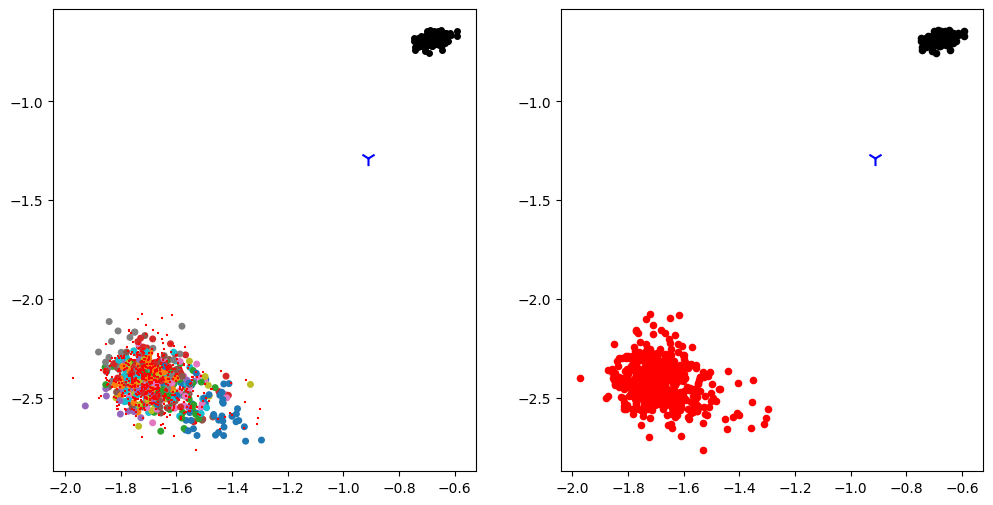

Epoch 0/150
{'G': 0.008440775326145357, 'POS': 0.9231922623000419, 'NEG': 0.9420752448440869, 'q20': 0.23603085279464722, 'q80': 0.2697360754013062, 'auc': 0.17105501882239382}


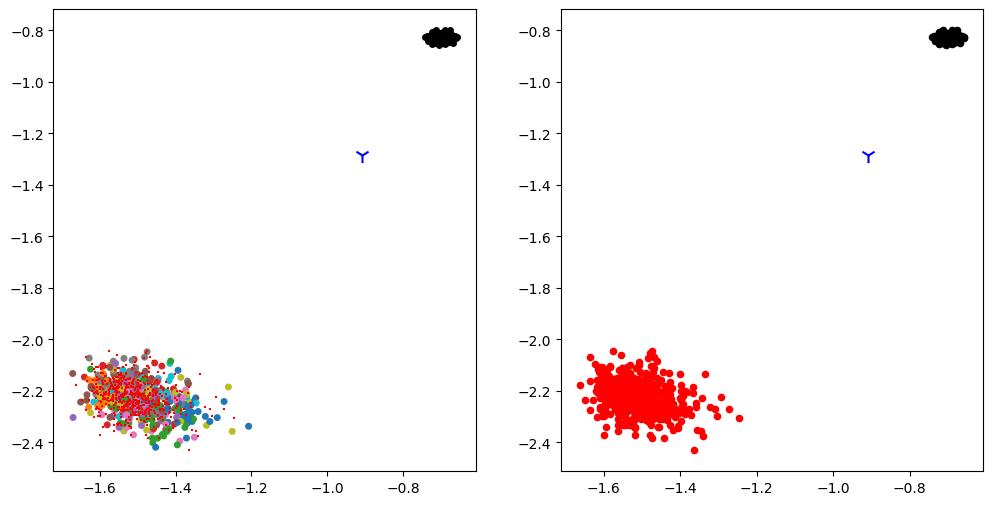

Epoch 1/150
{'G': 0.003171087817292907, 'POS': 0.9696519166421789, 'NEG': 0.9567968494602358, 'q20': 0.3125379681587219, 'q80': 0.3403716623783112, 'auc': 0.1306535555019305}


Epoch 2/150
{'G': 0.004414987943218604, 'POS': 0.9761662919129899, 'NEG': 0.9538081663249652, 'q20': 0.4366817831993103, 'q80': 0.47648243308067323, 'auc': 0.184433875}


Epoch 3/150
{'G': 0.004456200124968939, 'POS': 0.9802604157533219, 'NEG': 0.951998405365039, 'q20': 0.31500253081321716, 'q80': 0.34300519824028014, 'auc': 0.20968778909266408}


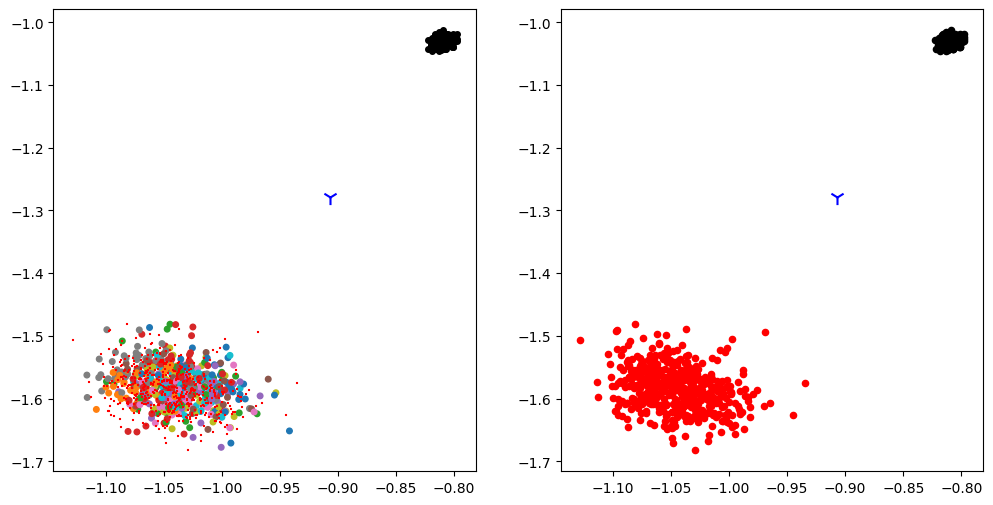

Epoch 4/150
{'G': 0.003698196997349736, 'POS': 0.9836148735302598, 'NEG': 0.9518031193249261, 'q20': 0.6964088916778565, 'q80': 0.7313433408737182, 'auc': 0.1297351891891892}


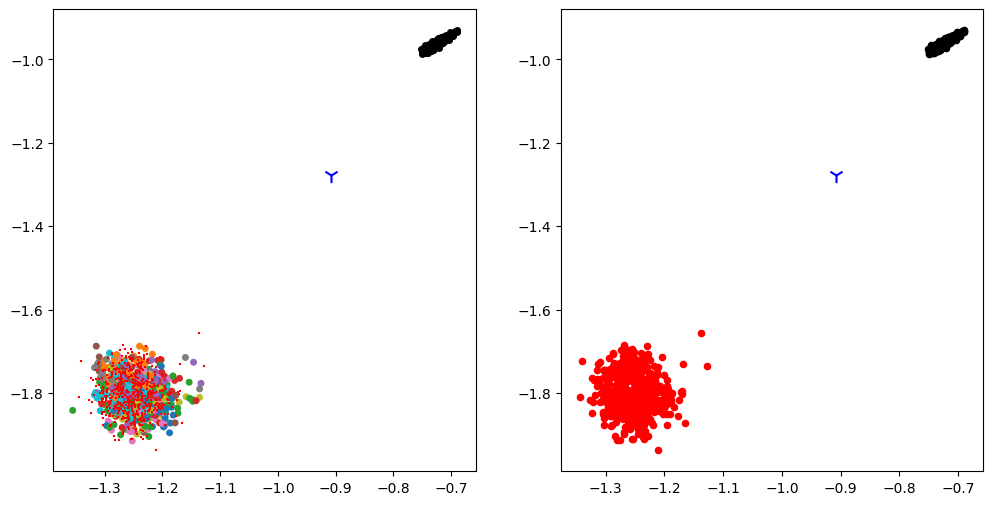

Epoch 5/150
{'G': 0.0039722247156940066, 'POS': 0.9842604148362492, 'NEG': 0.952061399849239, 'q20': 0.5138918876647949, 'q80': 0.5490059852600098, 'auc': 0.16847398552123552}


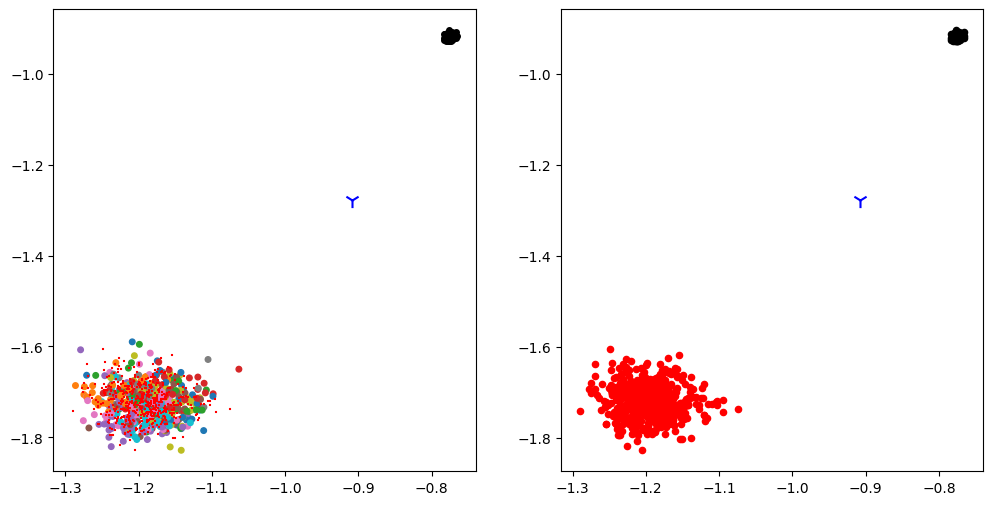

Epoch 6/150
{'G': 0.003376787770658668, 'POS': 0.9860590996264395, 'NEG': 0.9518099016726398, 'q20': 0.5706504702568054, 'q80': 0.6038915276527405, 'auc': 0.1761424058880309}


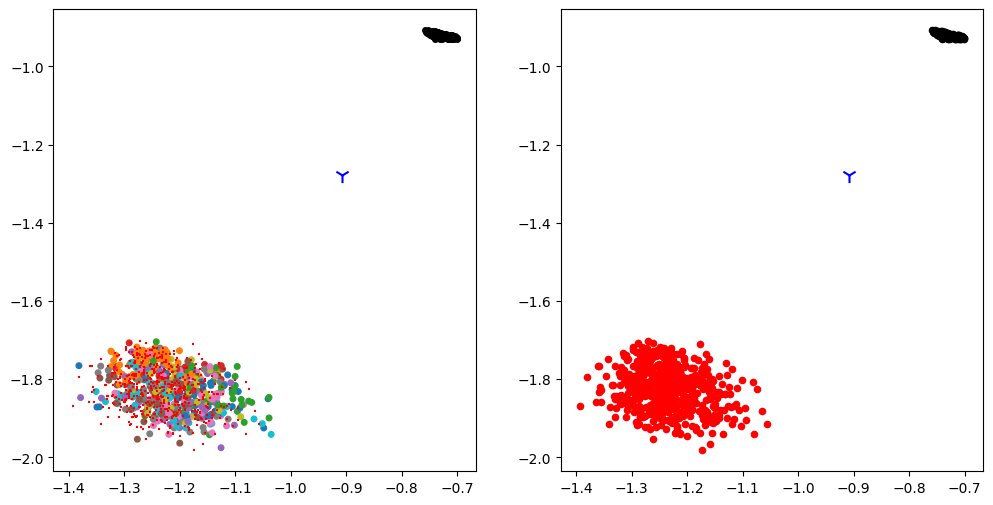

Epoch 7/150
{'G': 0.0043727489141648064, 'POS': 0.986046029941868, 'NEG': 0.9509866575696575, 'q20': 0.5049686431884766, 'q80': 0.550238561630249, 'auc': 0.3153518064671814}


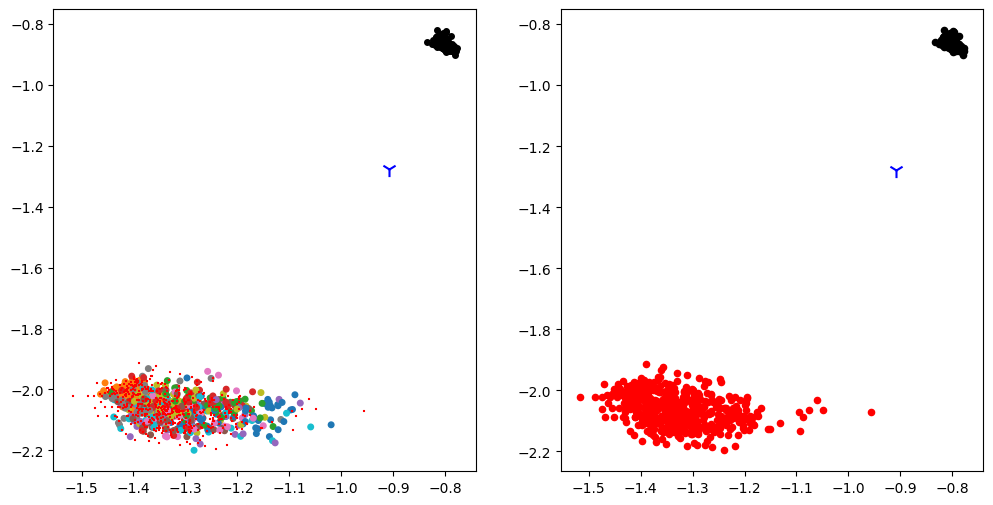

Epoch 8/150
{'G': 0.0033087824761216193, 'POS': 0.9888732889567865, 'NEG': 0.9508512440774994, 'q20': 0.3954237878322601, 'q80': 0.4250729322433472, 'auc': 0.1362434083011583}


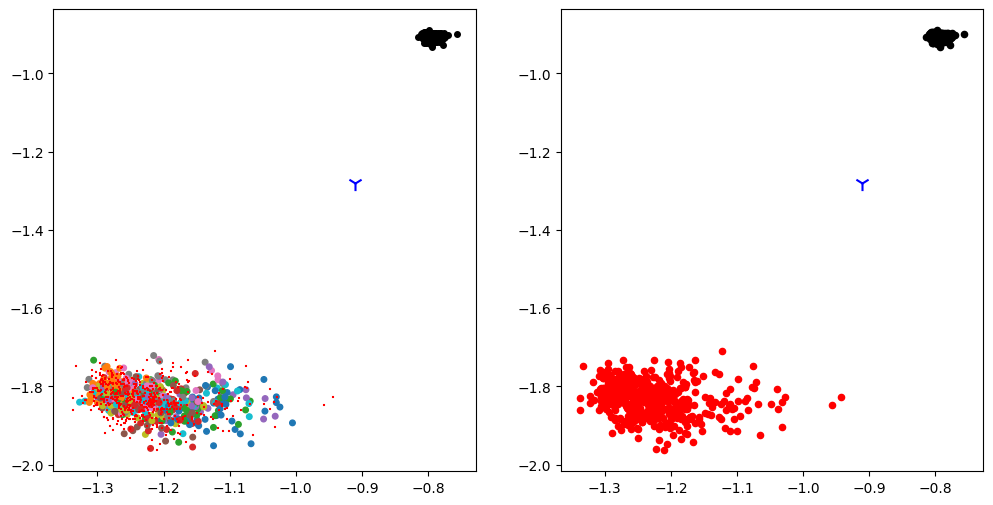

Epoch 9/150
{'G': 0.004317050018826369, 'POS': 0.9891422566320343, 'NEG': 0.95095930806101, 'q20': 0.5126143217086792, 'q80': 0.5436139106750488, 'auc': 0.16400851206563705}


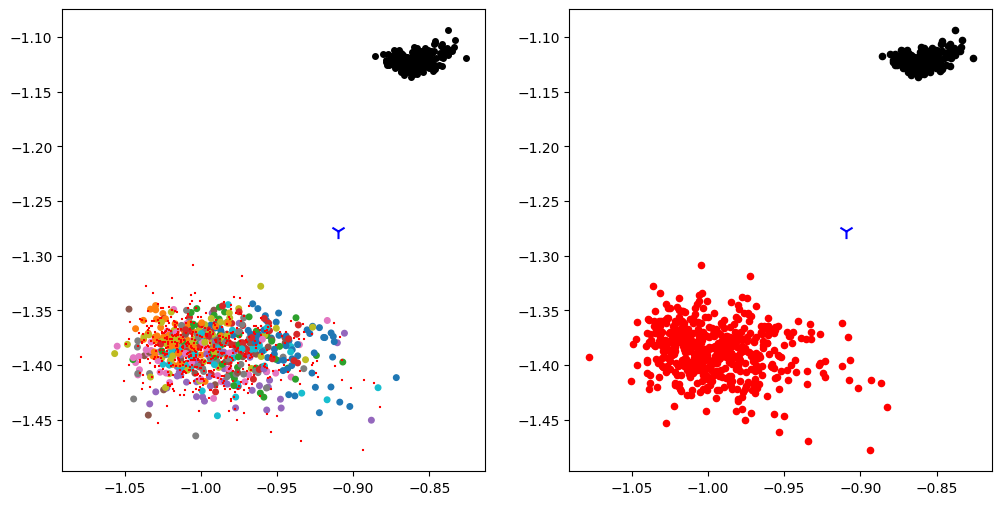

Epoch 10/150
{'G': 0.003239072480875411, 'POS': 0.9879364131101921, 'NEG': 0.952152932122318, 'q20': 0.8538712859153748, 'q80': 0.8869512557983399, 'auc': 0.2377384025096525}


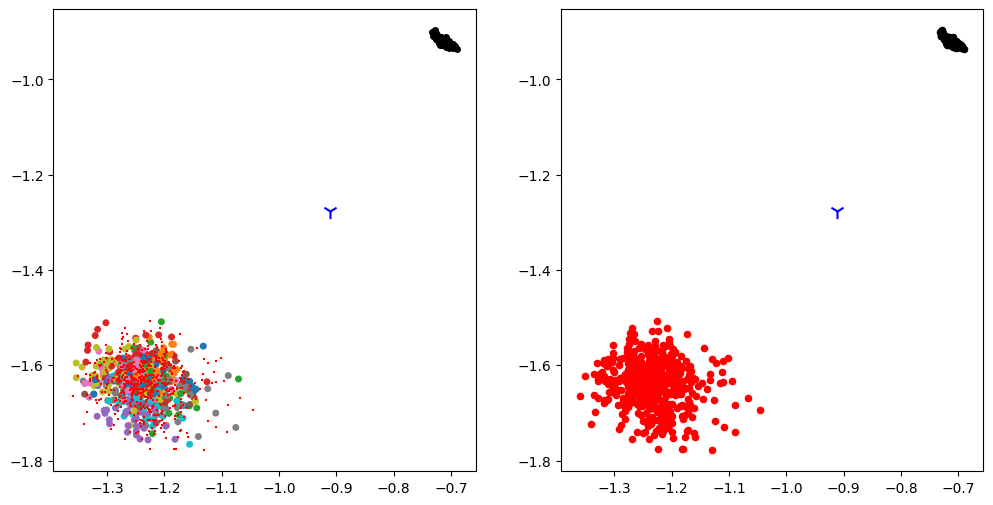

Epoch 11/150
{'G': 0.0032651278275702554, 'POS': 0.9870177222721612, 'NEG': 0.9510865563522778, 'q20': 0.5915639400482178, 'q80': 0.6343767404556274, 'auc': 0.21698391602316602}


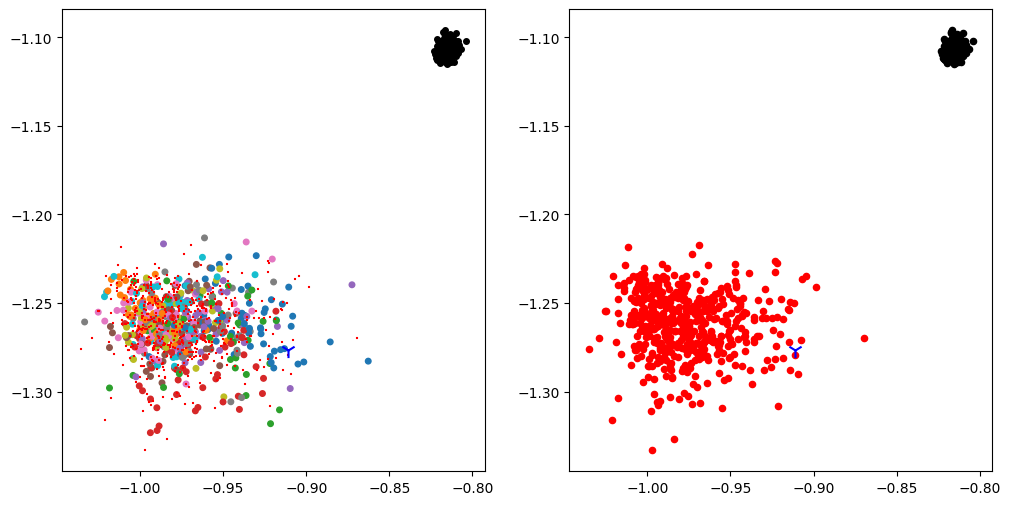

Epoch 12/150
{'G': 0.003281587749215236, 'POS': 0.9884187727848858, 'NEG': 0.9515573537425954, 'q20': 0.9173759341239929, 'q80': 0.9541134119033814, 'auc': 0.30265485376447876}


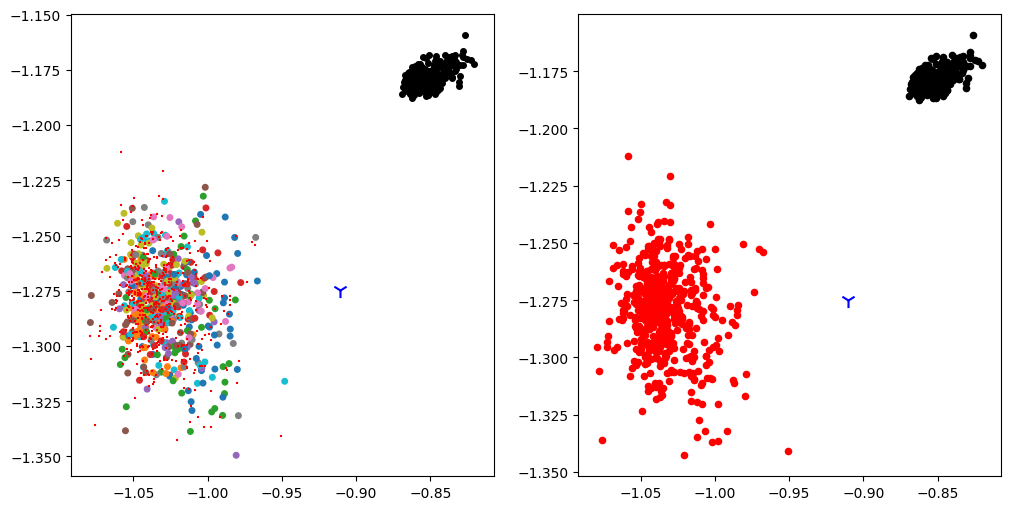

Epoch 13/150
{'G': 0.0027606816985197603, 'POS': 0.9901571785971555, 'NEG': 0.951468456147322, 'q20': 0.874000346660614, 'q80': 0.9002348184585571, 'auc': 0.15449504005791506}


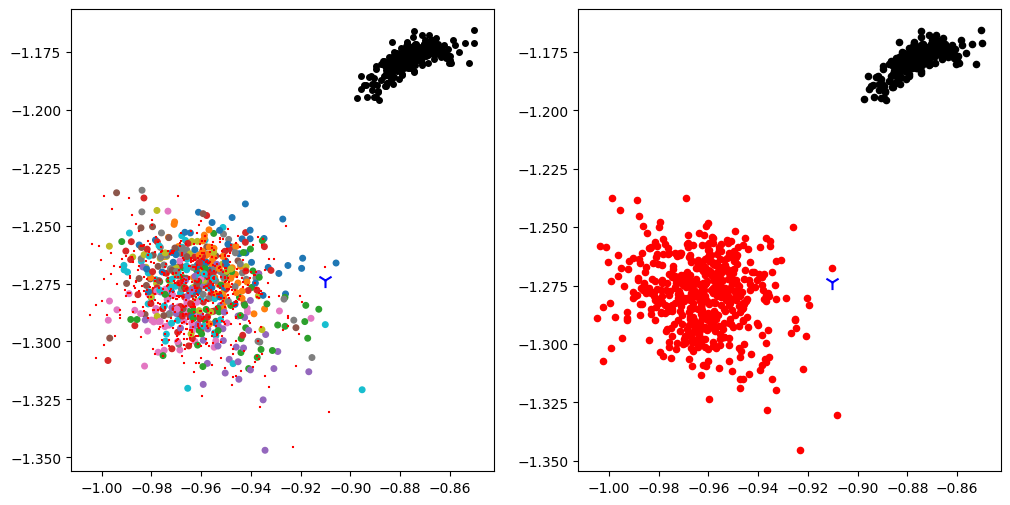

Epoch 14/150
{'G': 0.0026760674583147775, 'POS': 0.9911128161812642, 'NEG': 0.9513376236978625, 'q20': 0.9358846545219421, 'q80': 0.9592648267745971, 'auc': 0.3197861592664093}


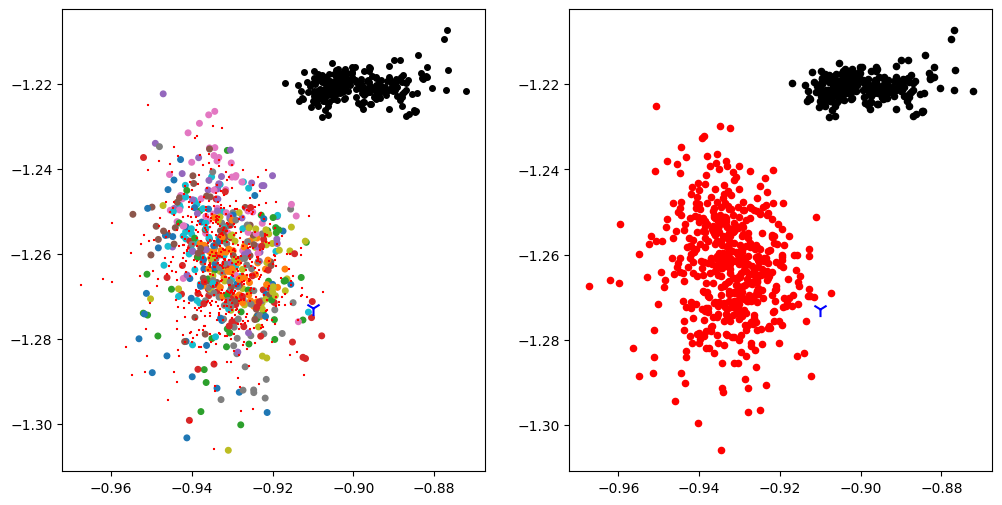

Epoch 15/150
{'G': 0.0027073458329077435, 'POS': 0.9912640846360212, 'NEG': 0.9513587142104534, 'q20': 0.9661917805671691, 'q80': 0.9825923800468445, 'auc': 0.5476200719111969}


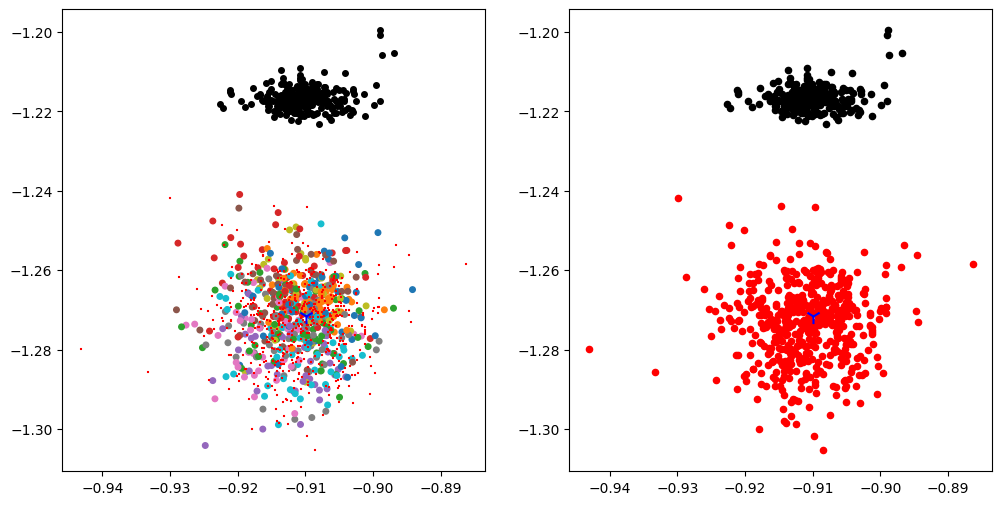

Epoch 16/150
{'G': 0.002612391080179099, 'POS': 0.9918288320366507, 'NEG': 0.9513351621149954, 'q20': 0.9847995400428772, 'q80': 0.995064640045166, 'auc': 0.8347496249999999}


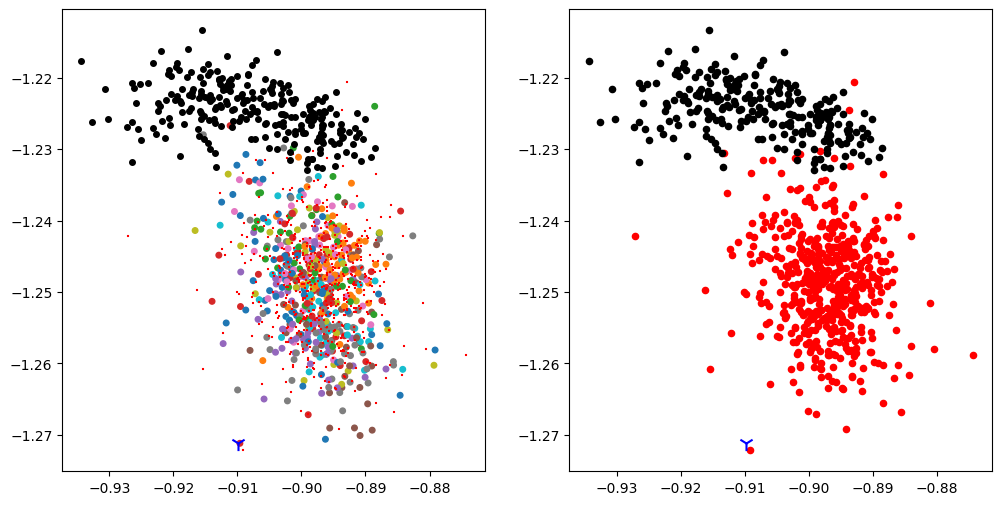

Epoch 17/150
{'G': 0.002595726059062649, 'POS': 0.9919228984602987, 'NEG': 0.9514638362154524, 'q20': 0.9687305927276612, 'q80': 0.979629111289978, 'auc': 0.8537062857142856}


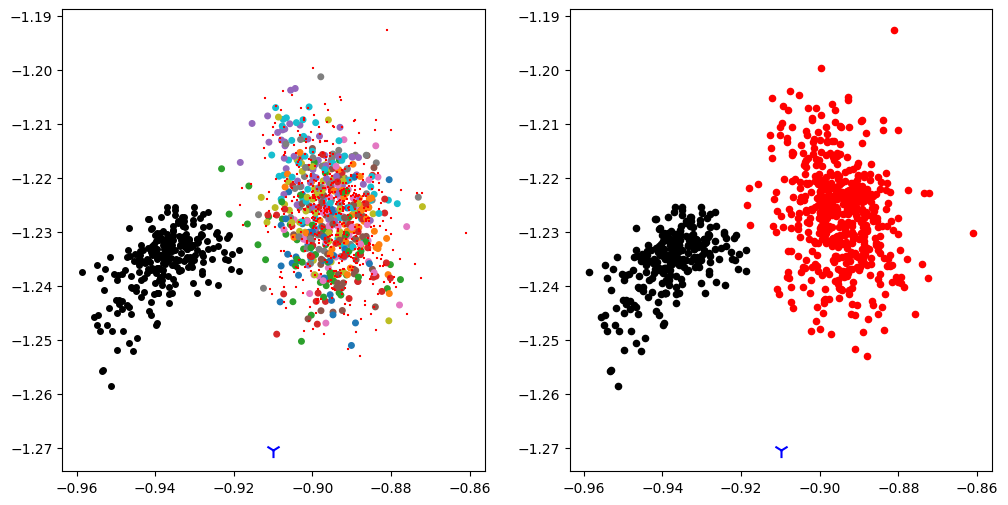

Epoch 18/150
{'G': 0.0025293929700944216, 'POS': 0.9916650847331293, 'NEG': 0.9520172418307647, 'q20': 0.9475761771202087, 'q80': 0.9607775449752808, 'auc': 0.8748344816602317}


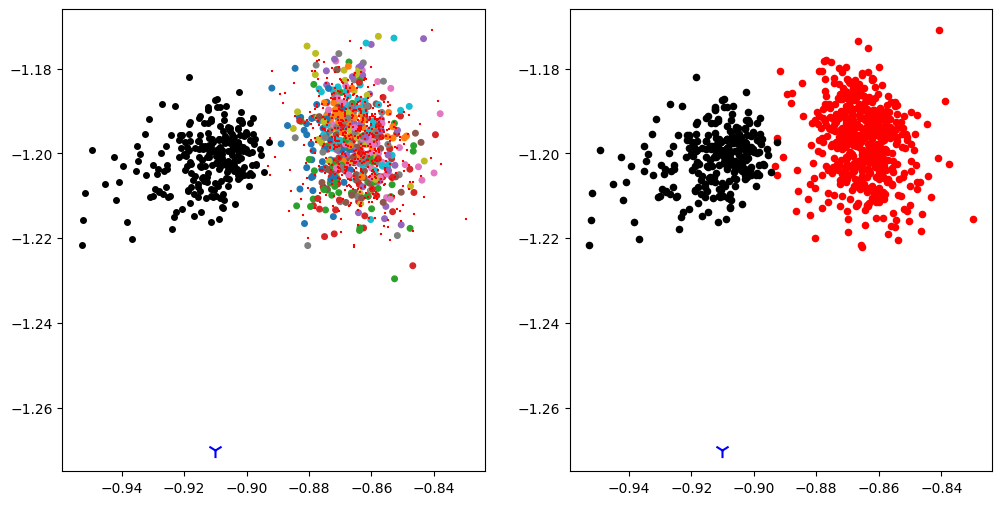

Epoch 19/150
{'G': 0.002450294599536735, 'POS': 0.9910091226543191, 'NEG': 0.9527826469335983, 'q20': 0.9112813830375671, 'q80': 0.9232159614562988, 'auc': 0.8531474768339768}


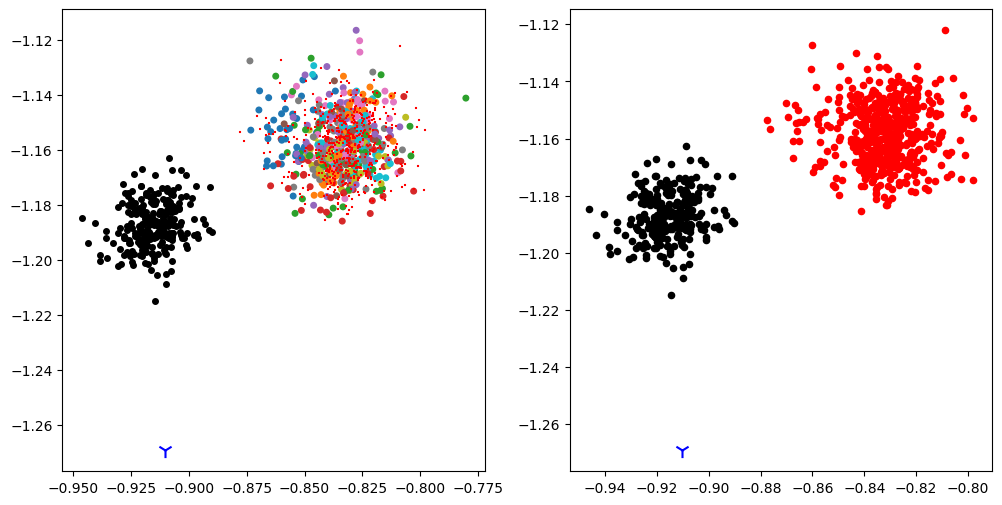

Epoch 20/150
{'G': 0.002390023225844939, 'POS': 0.9907368965494607, 'NEG': 0.9533530491501537, 'q20': 0.8644269466400146, 'q80': 0.8807201385498047, 'auc': 0.855124461872587}


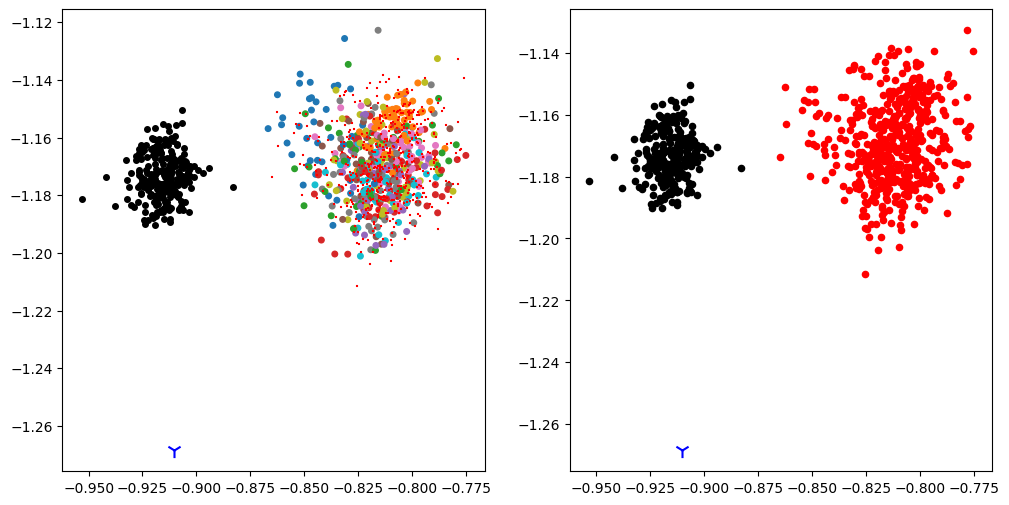

Epoch 21/150
{'G': 0.0023784712887803977, 'POS': 0.9906207009165018, 'NEG': 0.9533366618125931, 'q20': 0.8595043897628785, 'q80': 0.8805137753486634, 'auc': 0.7819563981660231}


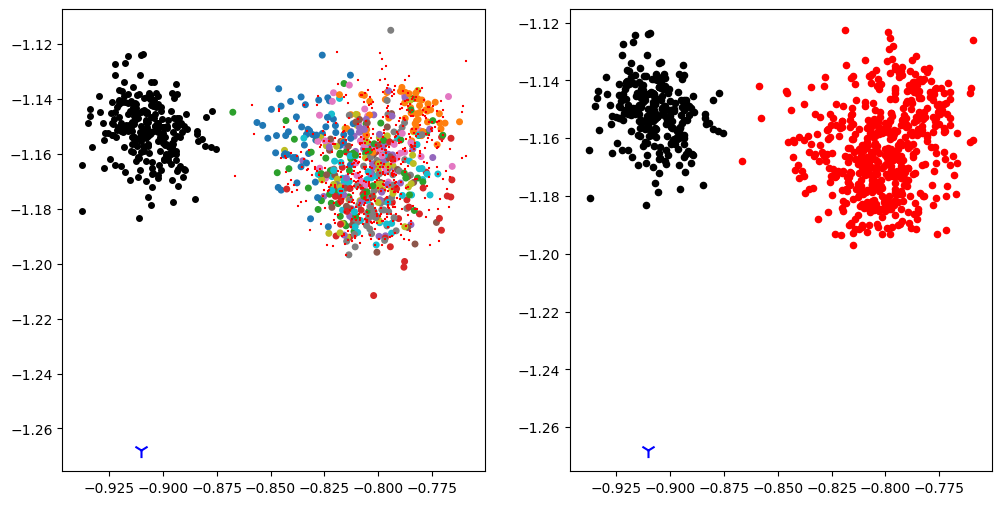

Epoch 22/150
{'G': 0.0022649796394659067, 'POS': 0.9900522204096129, 'NEG': 0.9545315924738007, 'q20': 0.8482945799827576, 'q80': 0.8734139919281005, 'auc': 0.756235042953668}


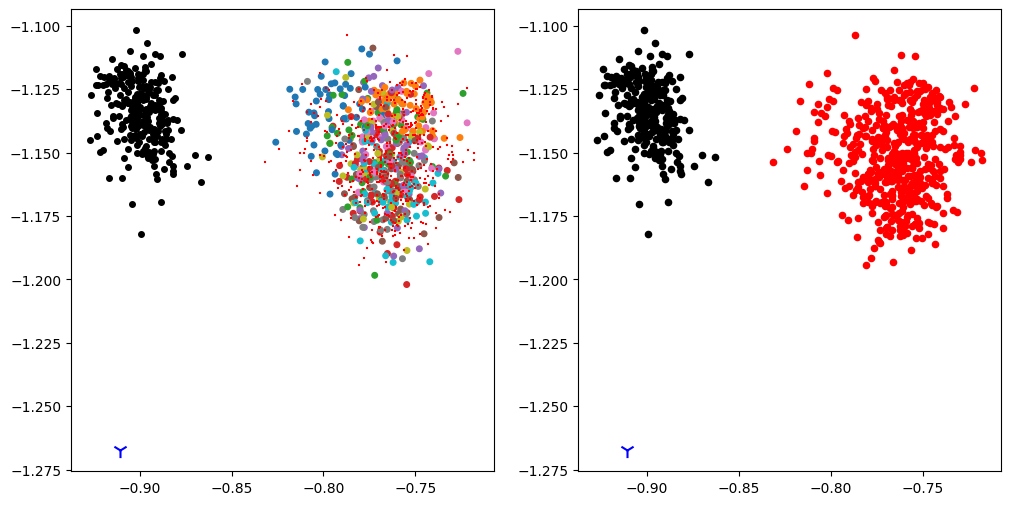

Epoch 23/150
{'G': 0.002133987690341959, 'POS': 0.9882689988943559, 'NEG': 0.9561176246671534, 'q20': 0.8170305967330933, 'q80': 0.8414780259132385, 'auc': 0.796330530888031}


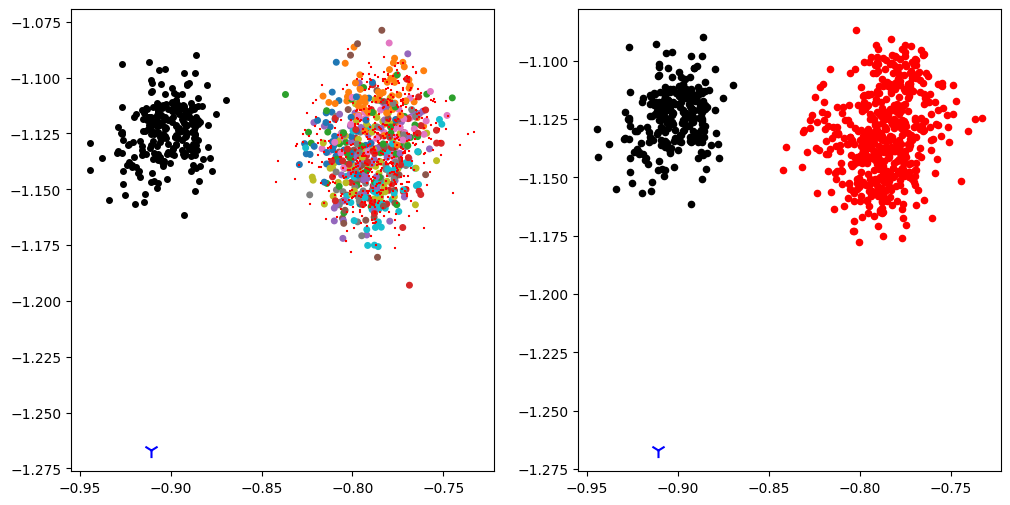

Epoch 24/150
{'G': 0.002055554014535299, 'POS': 0.9867659306475348, 'NEG': 0.9575902578164773, 'q20': 0.817874014377594, 'q80': 0.8458844900131226, 'auc': 0.7524539078185328}


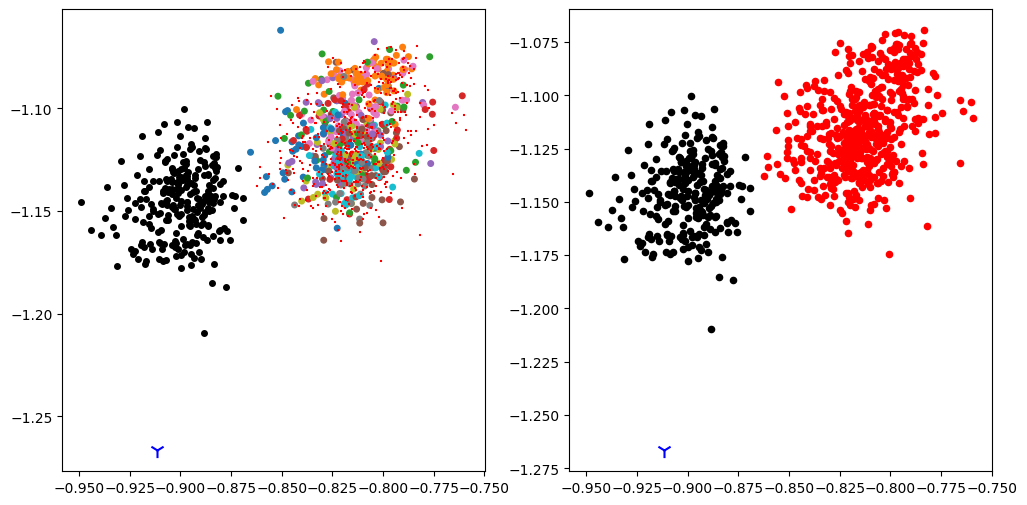

Epoch 25/150
{'G': 0.001908542119589116, 'POS': 0.9857690817257488, 'NEG': 0.9591961564031491, 'q20': 0.8171584248542786, 'q80': 0.8492490768432617, 'auc': 0.7528557668918919}


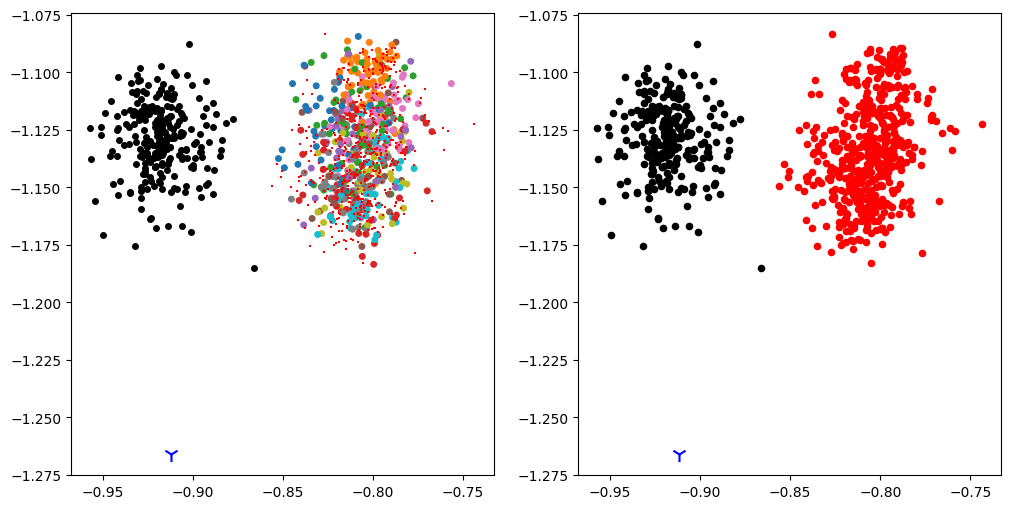

Epoch 26/150
{'G': 0.0018276436910180172, 'POS': 0.984565847718131, 'NEG': 0.960381896383981, 'q20': 0.8272434353828431, 'q80': 0.8590602993965148, 'auc': 0.7751047239382239}


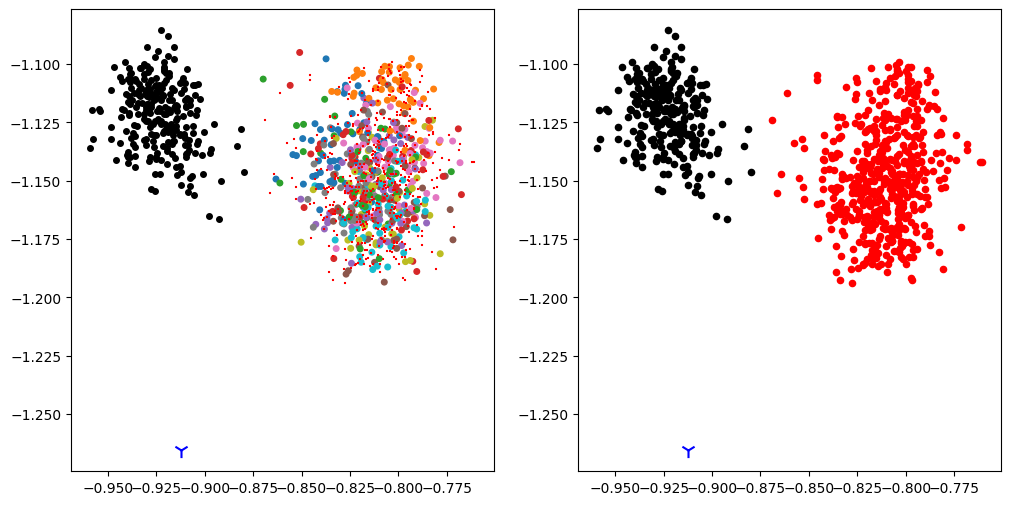

Epoch 27/150
{'G': 0.0018040381577004916, 'POS': 0.9851108076475831, 'NEG': 0.9600992624693588, 'q20': 0.8399754166603088, 'q80': 0.8700325846672058, 'auc': 0.7072637823359074}


Epoch 28/150
{'G': 0.0018597700777572832, 'POS': 0.985886158084056, 'NEG': 0.9591147257829271, 'q20': 0.8139144062995911, 'q80': 0.845549714565277, 'auc': 0.7178351105212355}


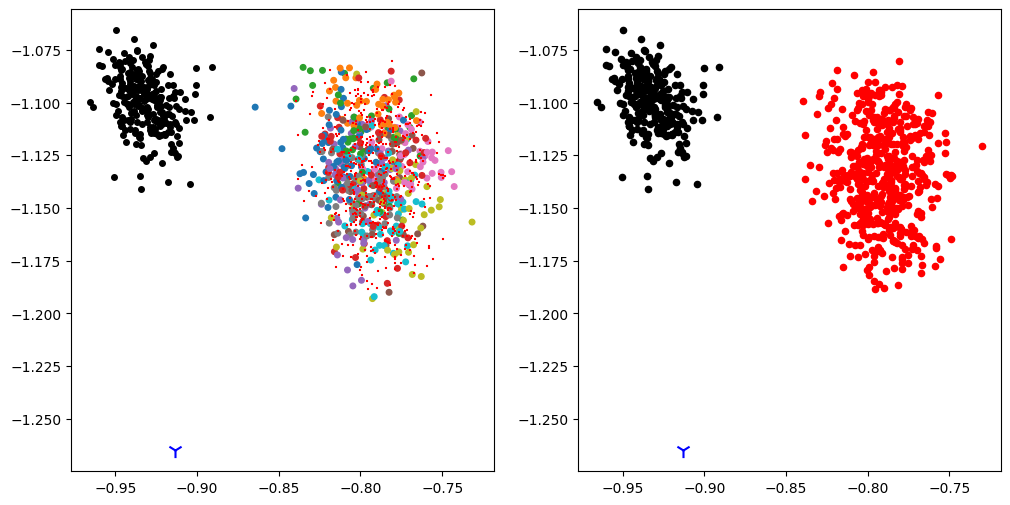

Epoch 29/150
{'G': 0.002065391557391431, 'POS': 0.9882069998966859, 'NEG': 0.956000318659394, 'q20': 0.8187970161437989, 'q80': 0.8482822060585022, 'auc': 0.7616160868725869}


Epoch 30/150
{'G': 0.002274679026004475, 'POS': 0.9905839986892652, 'NEG': 0.9533348753254043, 'q20': 0.8429484367370605, 'q80': 0.8711906433105469, 'auc': 0.7839167311776063}


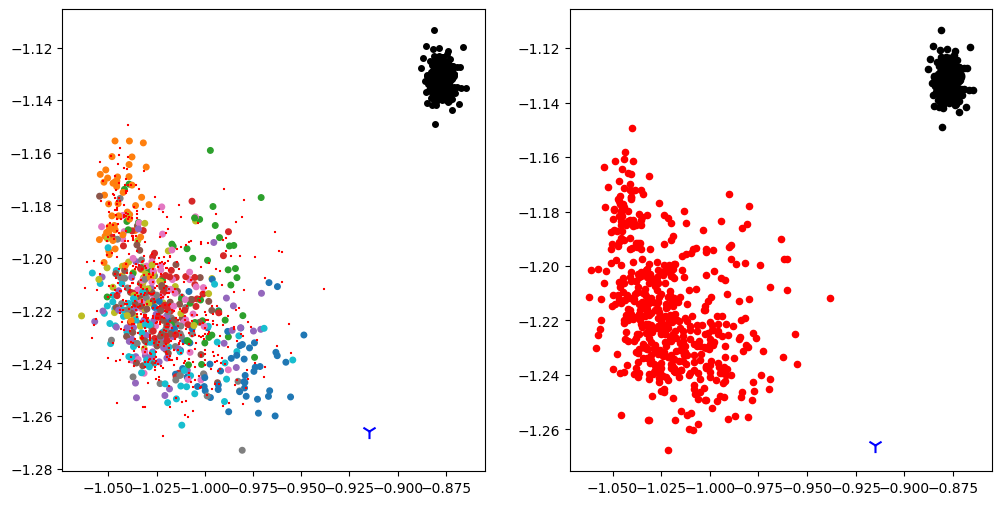

Epoch 31/150
{'G': 0.0032893784209164474, 'POS': 0.9916027669967619, 'NEG': 0.9506363465841899, 'q20': 0.8724319815635682, 'q80': 0.9086079001426697, 'auc': 0.5386392432432433}


Epoch 32/150
{'G': 0.0030267609324036186, 'POS': 0.9932436648208195, 'NEG': 0.950362969309028, 'q20': 0.9416458368301391, 'q80': 0.9616760730743408, 'auc': 0.9099204145752897}


Epoch 33/150
{'G': 0.002640644543623524, 'POS': 0.9940416573969795, 'NEG': 0.9504241347312927, 'q20': 0.8234970331192016, 'q80': 0.8475229620933533, 'auc': 0.8221418692084942}


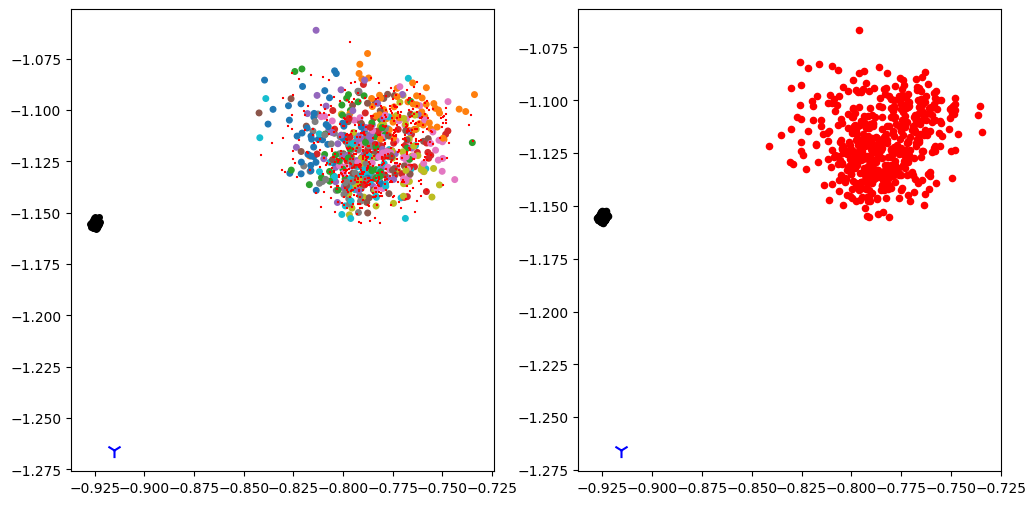

Epoch 34/150
{'G': 0.0025826629163371697, 'POS': 0.9945716298719459, 'NEG': 0.9502915043566527, 'q20': 0.8083392024040222, 'q80': 0.8339300870895385, 'auc': 0.8218493373552124}


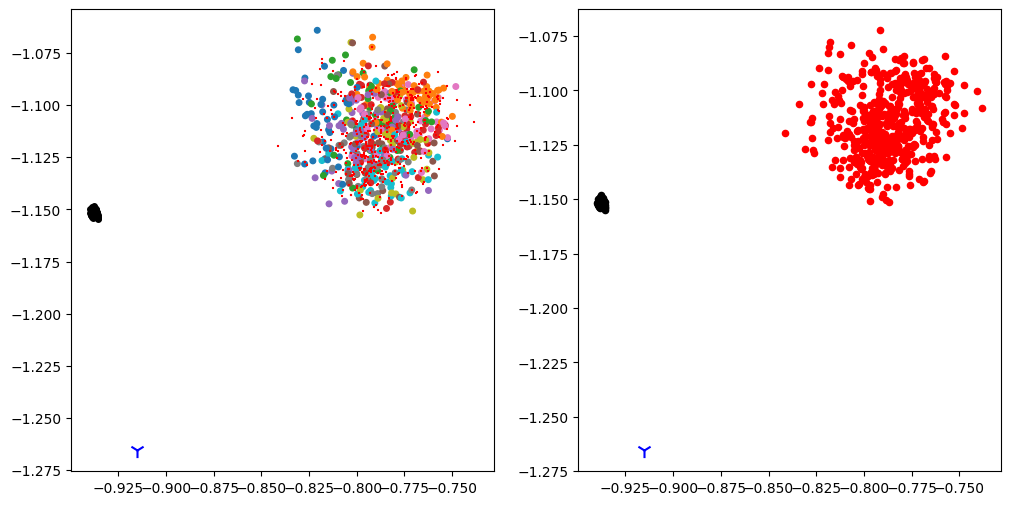

Epoch 35/150
{'G': 0.0025815343204289992, 'POS': 0.9948902447848941, 'NEG': 0.9503401554723793, 'q20': 0.806967294216156, 'q80': 0.8327361345291138, 'auc': 0.8205461298262549}


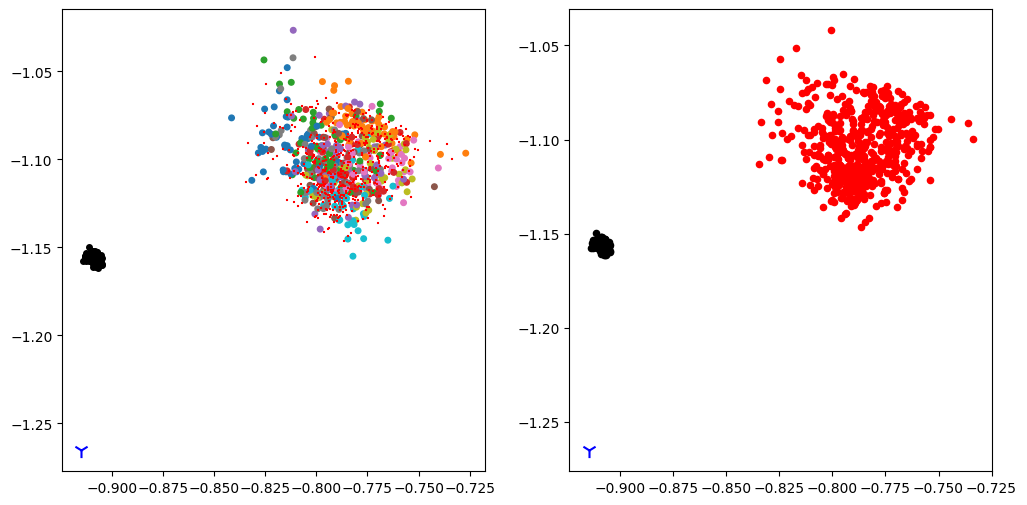

Epoch 36/150
{'G': 0.0025822491499720448, 'POS': 0.9951452699297273, 'NEG': 0.9502634853442341, 'q20': 0.7983236074447632, 'q80': 0.8243040084838867, 'auc': 0.8597008682432433}


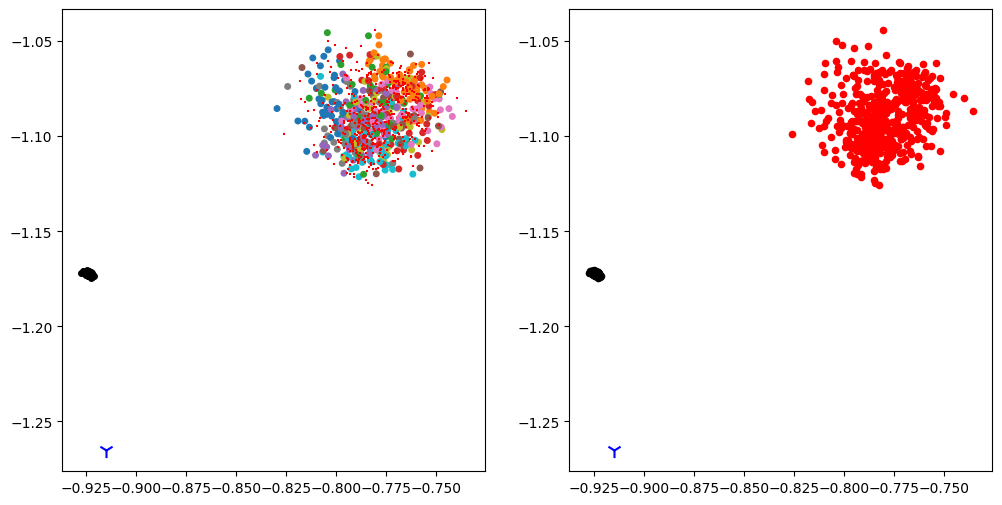

Epoch 37/150
{'G': 0.0025859318769423725, 'POS': 0.9952872394244554, 'NEG': 0.9502819817203448, 'q20': 0.7878536581993103, 'q80': 0.8113691568374634, 'auc': 0.8666116307915057}


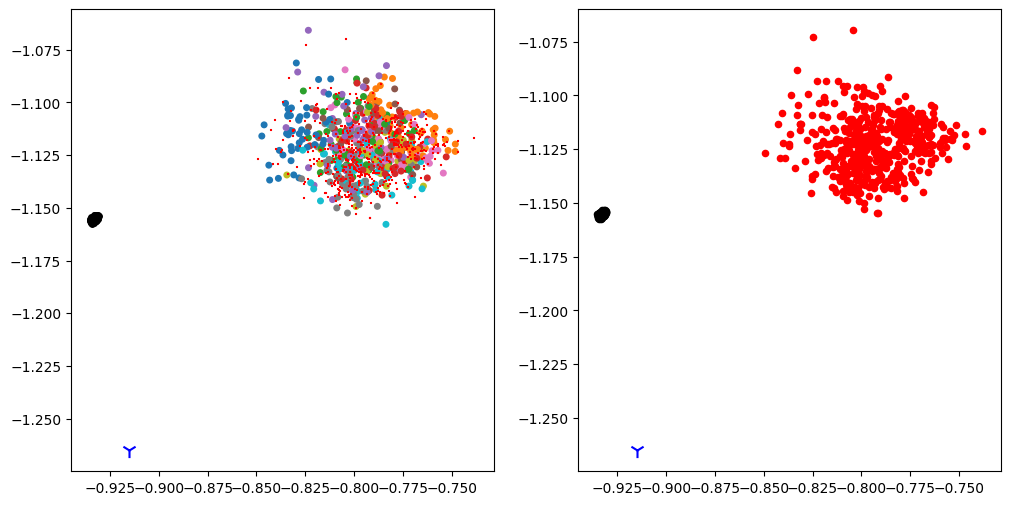

Epoch 38/150
{'G': 0.0025503406170080466, 'POS': 0.9957349321989617, 'NEG': 0.9501643204994039, 'q20': 0.8160679817199707, 'q80': 0.8400520563125611, 'auc': 0.8414177582046332}


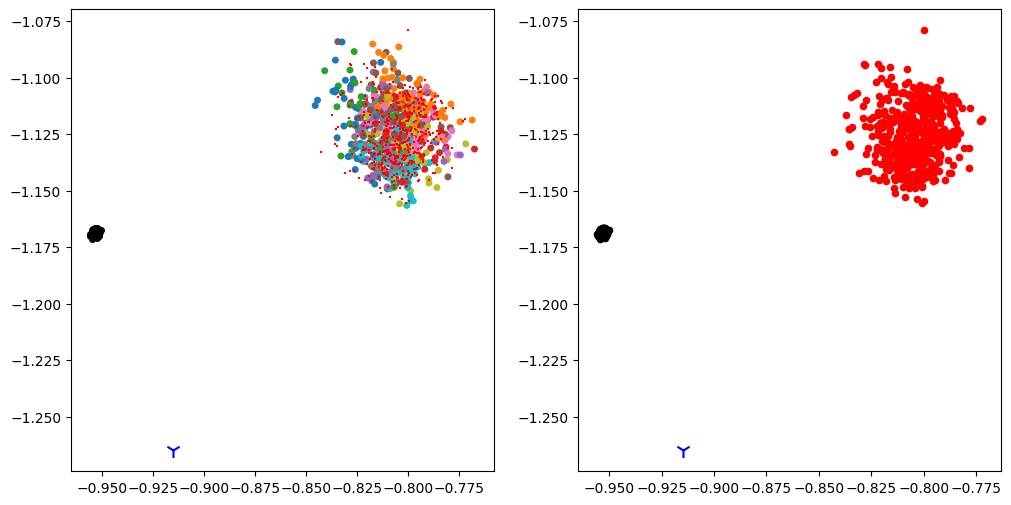

Epoch 39/150
{'G': 0.00256752620896956, 'POS': 0.9955201048586668, 'NEG': 0.9502573995702048, 'q20': 0.8261456608772277, 'q80': 0.8455328941345215, 'auc': 0.886566638996139}


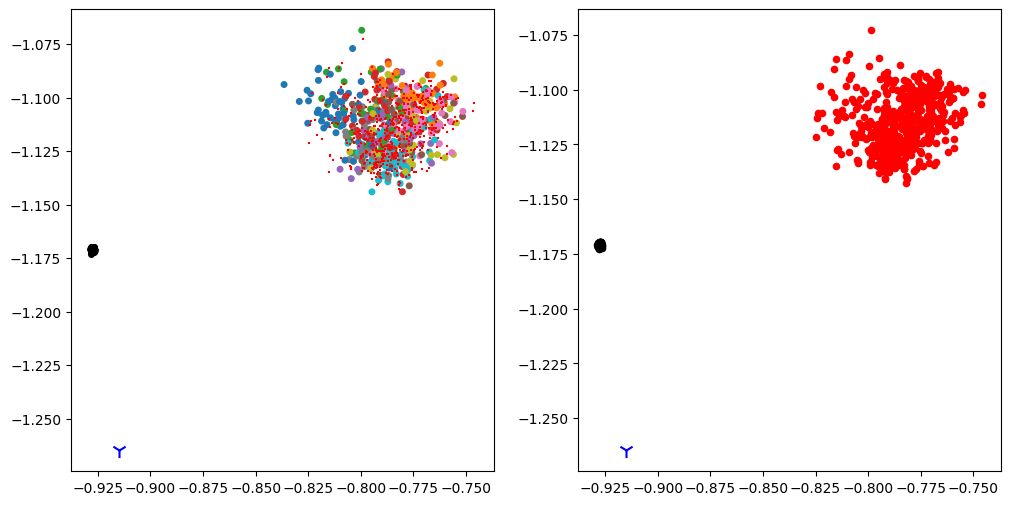

Epoch 40/150
{'G': 0.002551644569389951, 'POS': 0.9962208581123271, 'NEG': 0.9501253817635559, 'q20': 0.8082003712654113, 'q80': 0.8291847348213196, 'auc': 0.840096248069498}


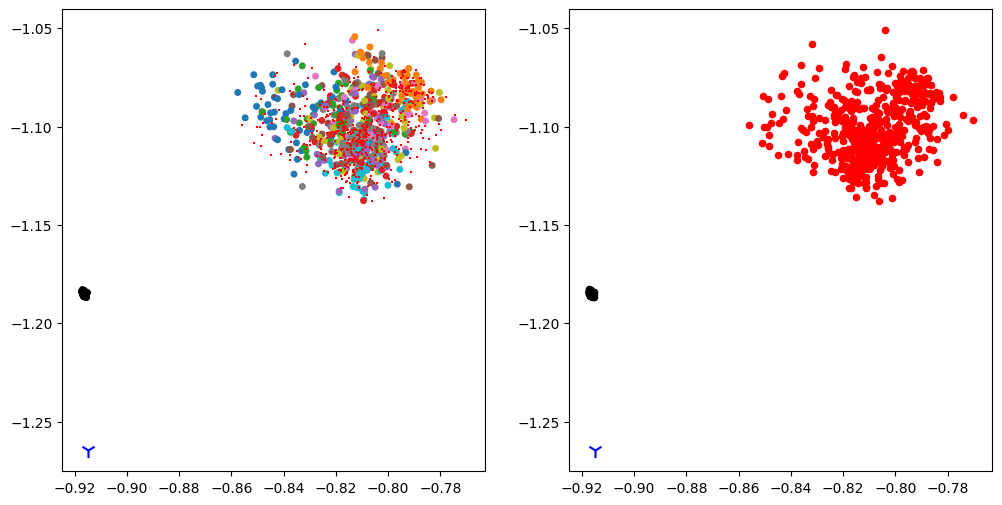

Epoch 41/150
{'G': 0.0025695818041993387, 'POS': 0.9959972335585653, 'NEG': 0.9502647507673642, 'q20': 0.8076258301734924, 'q80': 0.8325210809707642, 'auc': 0.8572978112934362}


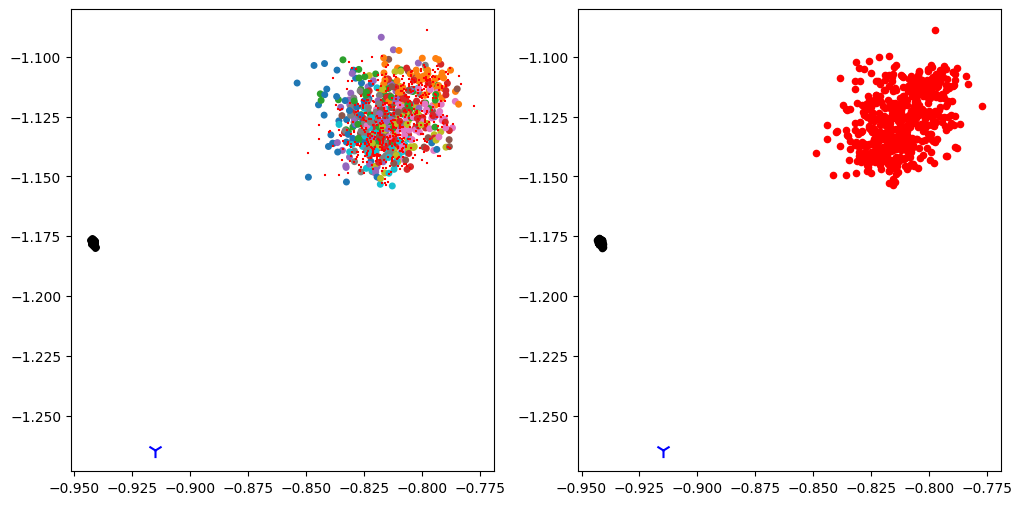

Epoch 42/150
{'G': 0.0025635369271953413, 'POS': 0.9959760688261182, 'NEG': 0.9502239369634372, 'q20': 0.8309618353843689, 'q80': 0.851856803894043, 'auc': 0.8705154831081081}


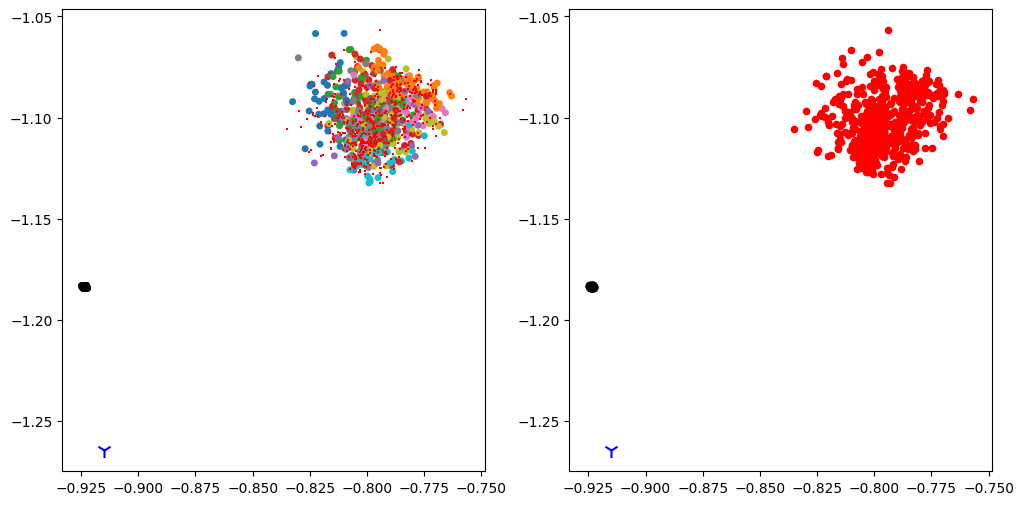

Epoch 43/150
{'G': 0.0025441751265322474, 'POS': 0.9961931161534812, 'NEG': 0.9501519696290559, 'q20': 0.8039310932159424, 'q80': 0.8258047461509704, 'auc': 0.8815567012548262}


Epoch 44/150
{'G': 0.0025655487904758024, 'POS': 0.996291537274684, 'NEG': 0.9502135834205888, 'q20': 0.8237462997436523, 'q80': 0.8459104776382447, 'auc': 0.8286750622586873}


Epoch 45/150
{'G': 0.002567783946286577, 'POS': 0.9961483134135508, 'NEG': 0.9502268362401137, 'q20': 0.8230275273323059, 'q80': 0.842634093761444, 'auc': 0.914704766891892}


Epoch 46/150
{'G': 0.0025536461000038838, 'POS': 0.996182564225024, 'NEG': 0.950156288233393, 'q20': 0.8107195854187011, 'q80': 0.8323663473129272, 'auc': 0.8960238638996139}


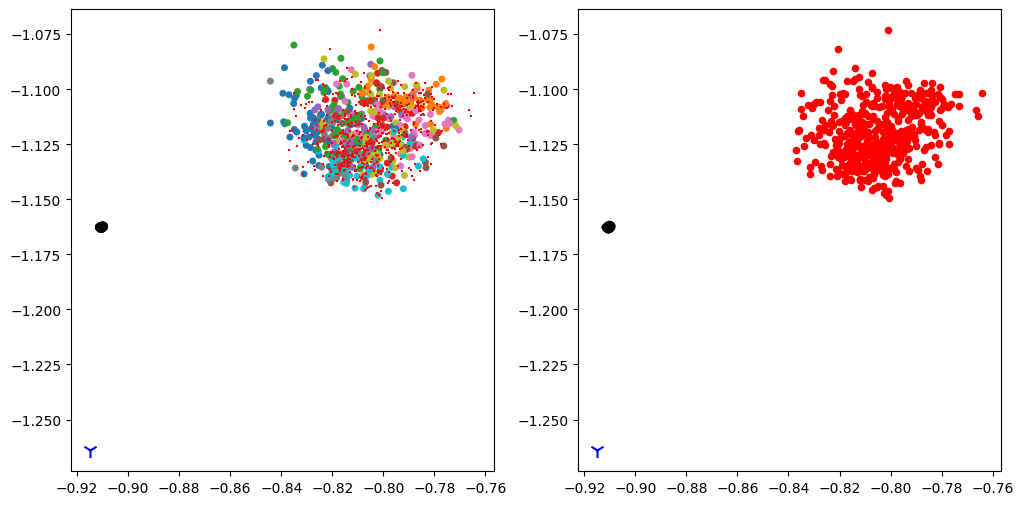

Epoch 47/150
{'G': 0.002580705317241678, 'POS': 0.9963938243099367, 'NEG': 0.9502807863231407, 'q20': 0.821011483669281, 'q80': 0.8431638956069947, 'auc': 0.8963123272200773}


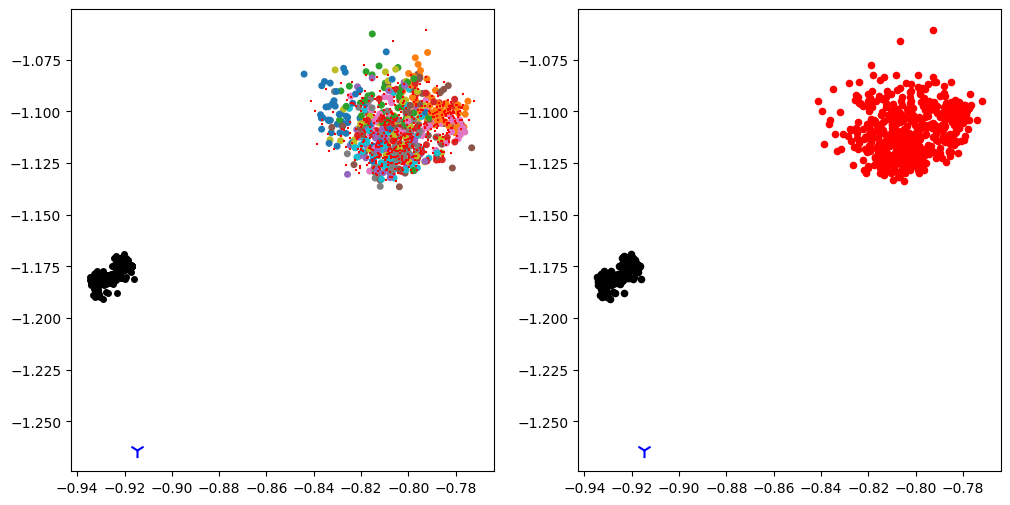

Epoch 48/150
{'G': 0.002587338193639446, 'POS': 0.9960338735122924, 'NEG': 0.9504109763387424, 'q20': 0.8131443619728088, 'q80': 0.8339998364448548, 'auc': 0.900644260135135}


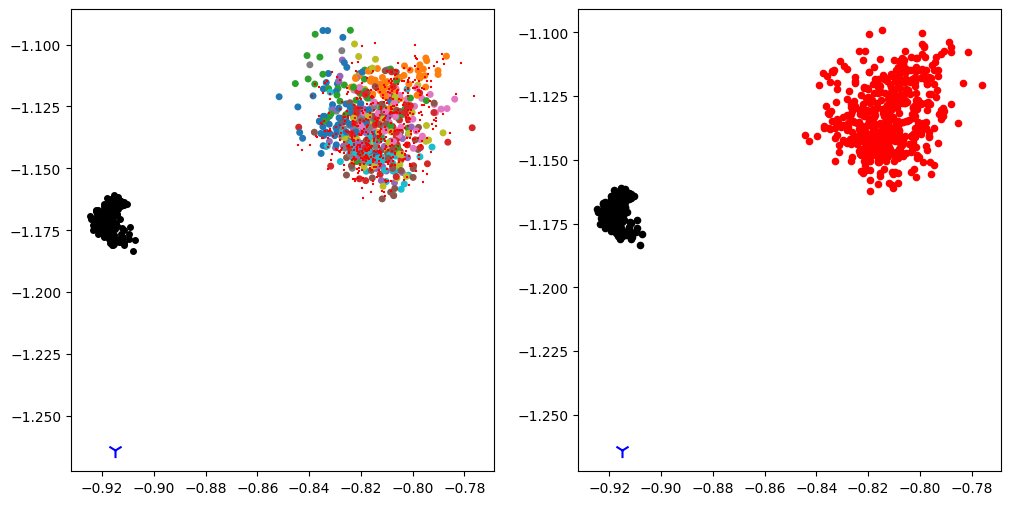

Epoch 49/150
{'G': 0.0025909791064105117, 'POS': 0.9947366764042169, 'NEG': 0.95082320828936, 'q20': 0.8361806273460388, 'q80': 0.8552779078483581, 'auc': 0.8594353735521236}


Epoch 50/150
{'G': 0.0025634517089457814, 'POS': 0.9945498693472287, 'NEG': 0.9509565523946717, 'q20': 0.818065345287323, 'q80': 0.8363551139831543, 'auc': 0.8866616394787645}


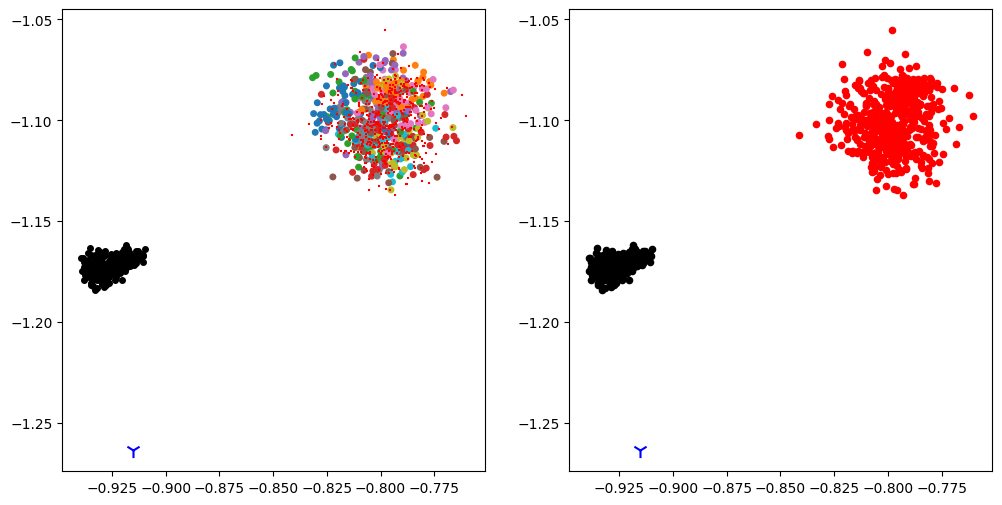

Epoch 51/150
{'G': 0.002542024492216644, 'POS': 0.9945328858361315, 'NEG': 0.9509464079128908, 'q20': 0.8062806248664856, 'q80': 0.8258478879928589, 'auc': 0.8735349565637065}


Epoch 52/150
{'G': 0.00250983770230789, 'POS': 0.9945859085522226, 'NEG': 0.9509475096456532, 'q20': 0.8195441126823425, 'q80': 0.8363139867782593, 'auc': 0.9047736805019304}


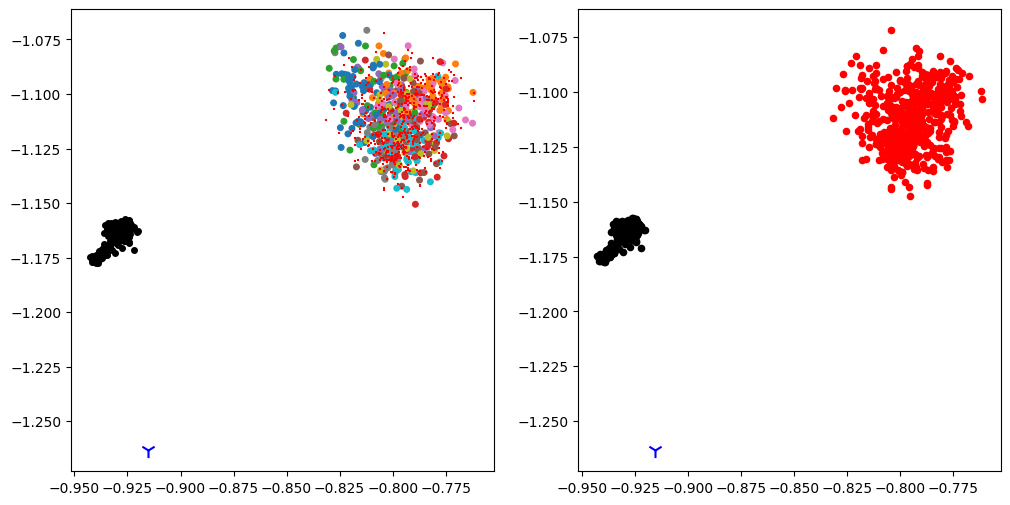

Epoch 53/150
{'G': 0.0025276536971374328, 'POS': 0.9948591511132621, 'NEG': 0.950750558106884, 'q20': 0.8128222465515137, 'q80': 0.8326972961425781, 'auc': 0.873443013996139}


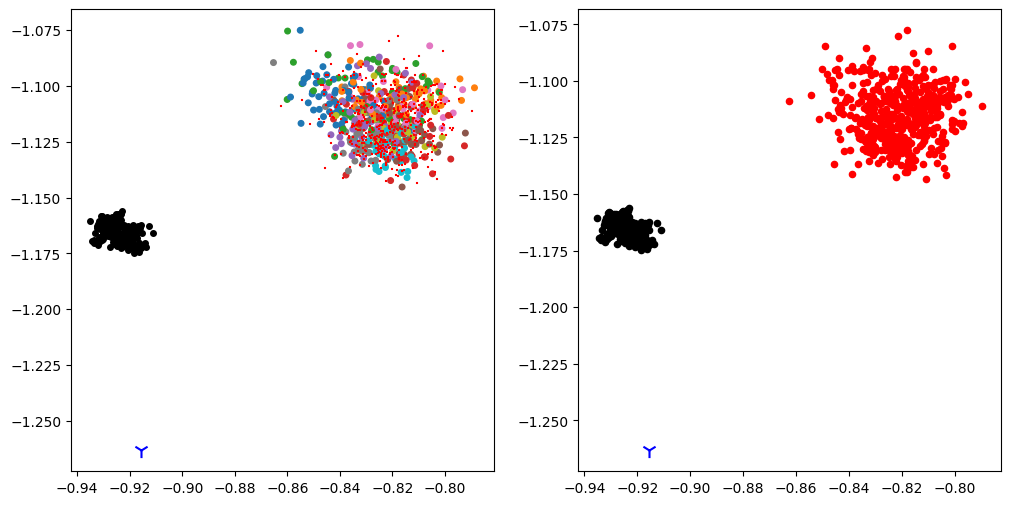

Epoch 54/150
{'G': 0.002519128333552798, 'POS': 0.9947535761637982, 'NEG': 0.950918055800741, 'q20': 0.829305636882782, 'q80': 0.8461965203285218, 'auc': 0.911798167953668}


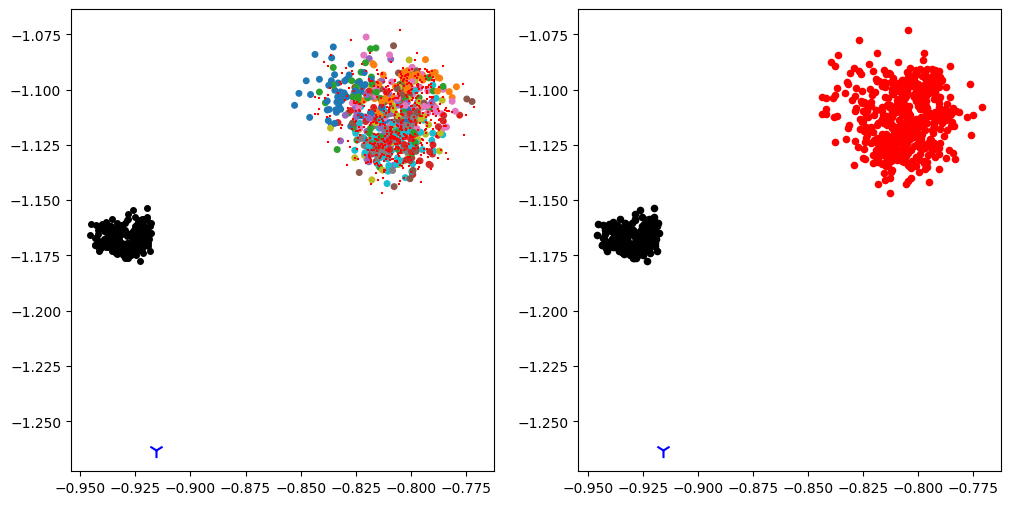

Epoch 55/150
{'G': 0.002515607652242488, 'POS': 0.9945518726479016, 'NEG': 0.9510028688892372, 'q20': 0.8200866937637329, 'q80': 0.83982412815094, 'auc': 0.874625166023166}


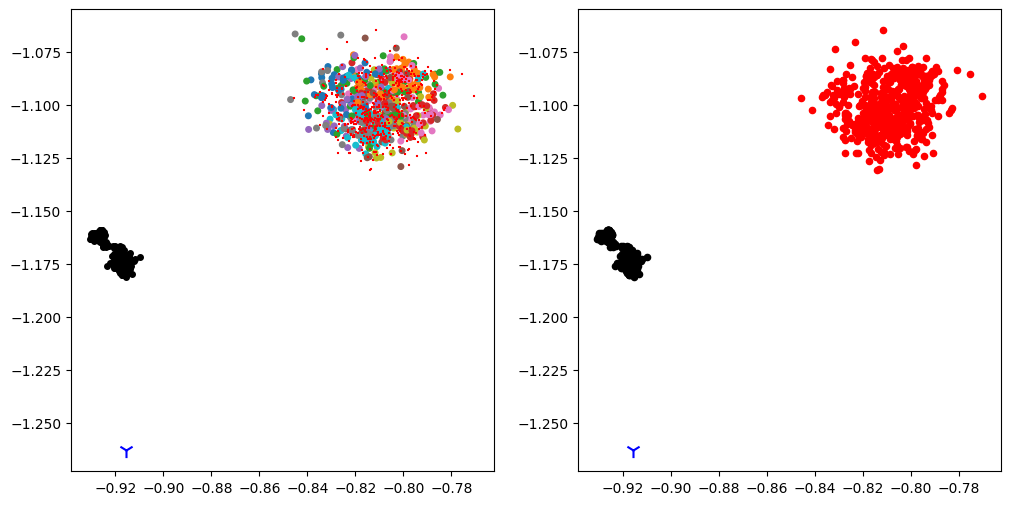

Epoch 56/150
{'G': 0.0025330825571292467, 'POS': 0.9952264055768564, 'NEG': 0.9506385617418838, 'q20': 0.8136493682861328, 'q80': 0.830938184261322, 'auc': 0.9012777499999999}


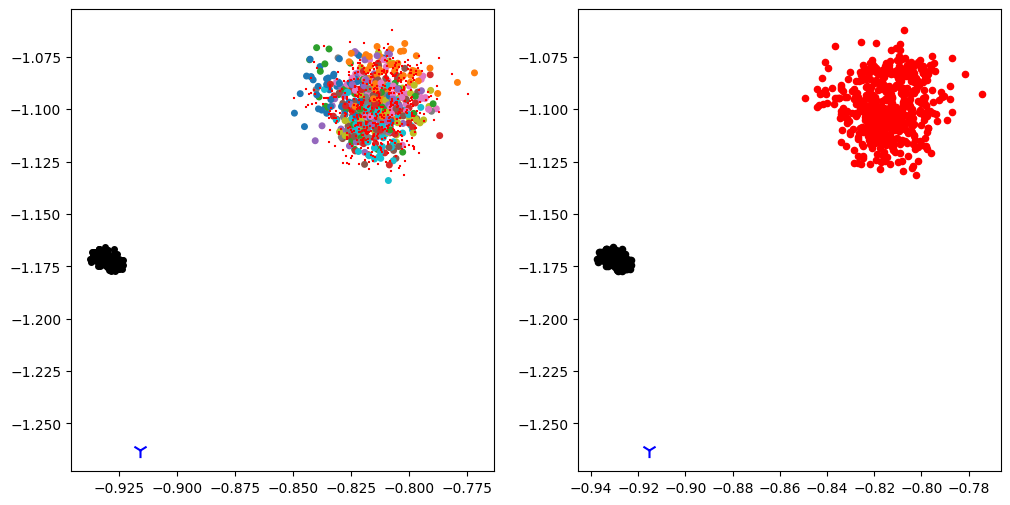

Epoch 57/150
{'G': 0.0025334695492114532, 'POS': 0.9955879521014085, 'NEG': 0.9505120359504147, 'q20': 0.8141084551811218, 'q80': 0.8320796132087708, 'auc': 0.8871903281853282}


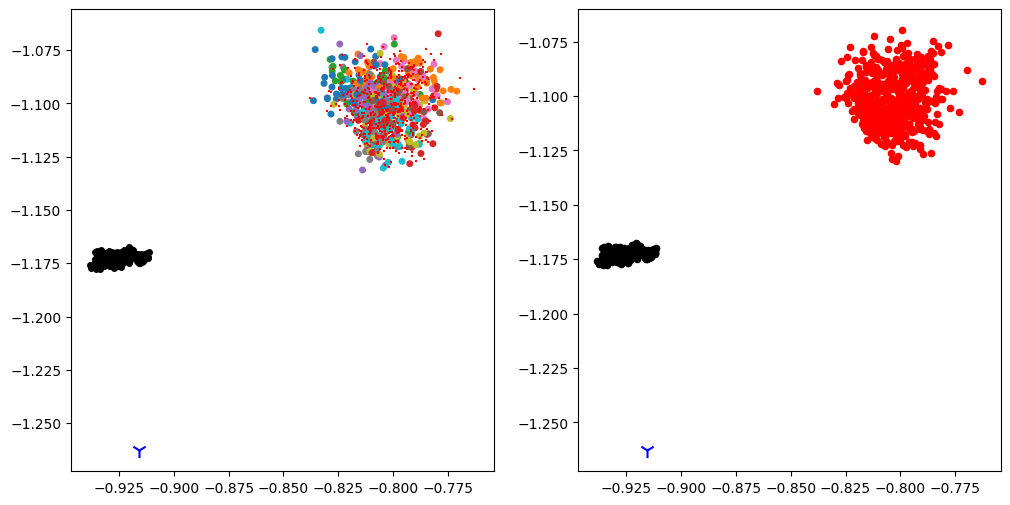

Epoch 58/150
{'G': 0.002516172384209772, 'POS': 0.9958508468385953, 'NEG': 0.9504074718652249, 'q20': 0.8105667233467102, 'q80': 0.8280724167823792, 'auc': 0.9002408431467182}


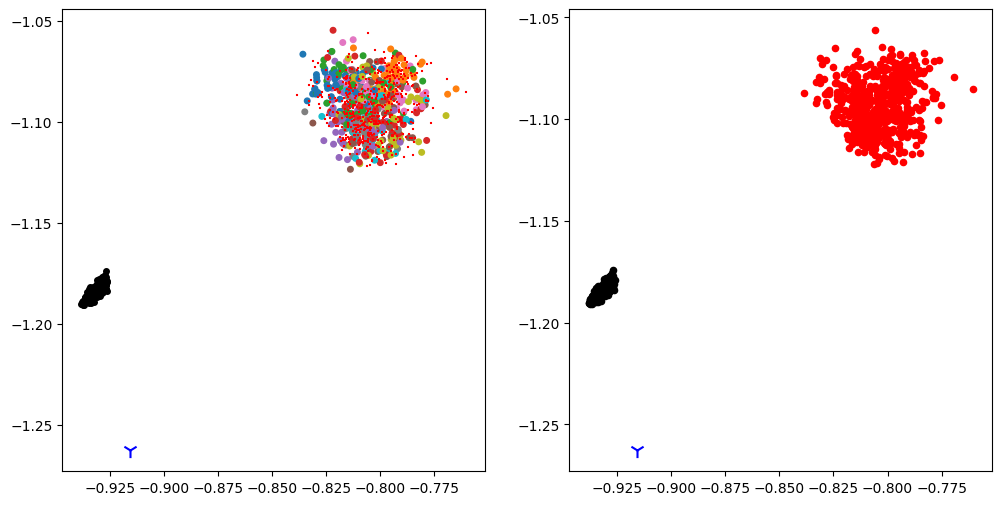

Epoch 59/150
{'G': 0.0025266597815938215, 'POS': 0.9957140634563177, 'NEG': 0.950539217701853, 'q20': 0.8052265405654907, 'q80': 0.8235583066940307, 'auc': 0.8707728658301158}


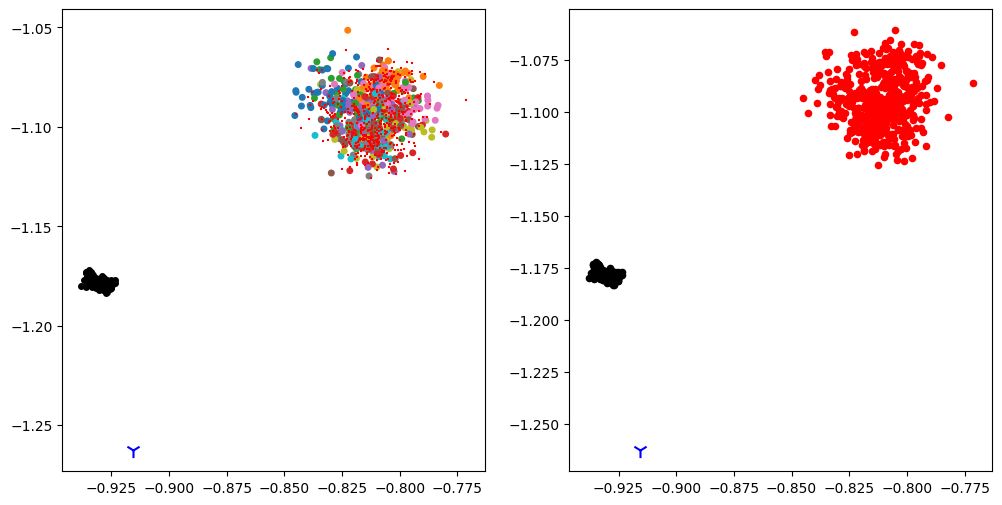

Epoch 60/150
{'G': 0.002532322226322568, 'POS': 0.9959893324481908, 'NEG': 0.9504263684439507, 'q20': 0.8097026586532593, 'q80': 0.8282737612724305, 'auc': 0.9045868354247104}


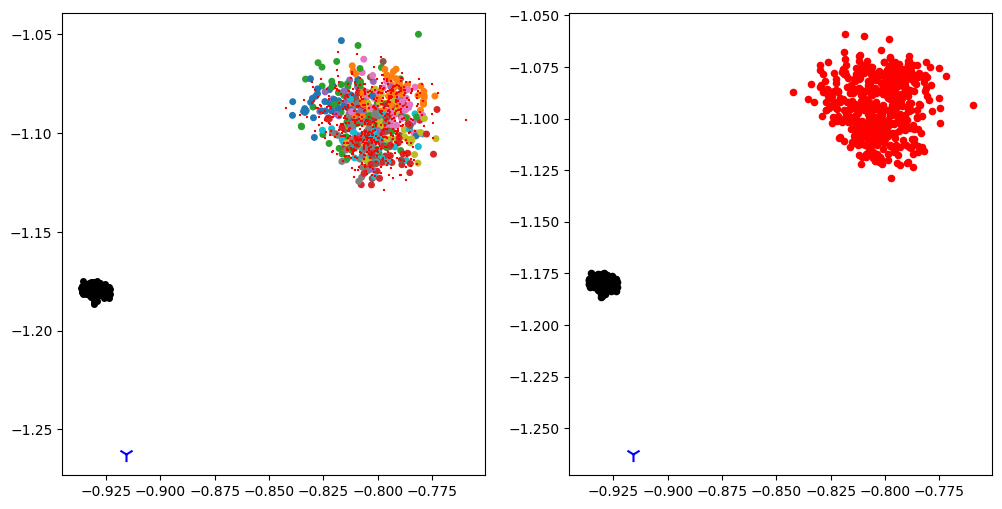

Epoch 61/150
{'G': 0.002520907258461994, 'POS': 0.9963897807257516, 'NEG': 0.950292213385039, 'q20': 0.8053729295730591, 'q80': 0.8236166596412658, 'auc': 0.878341223938224}


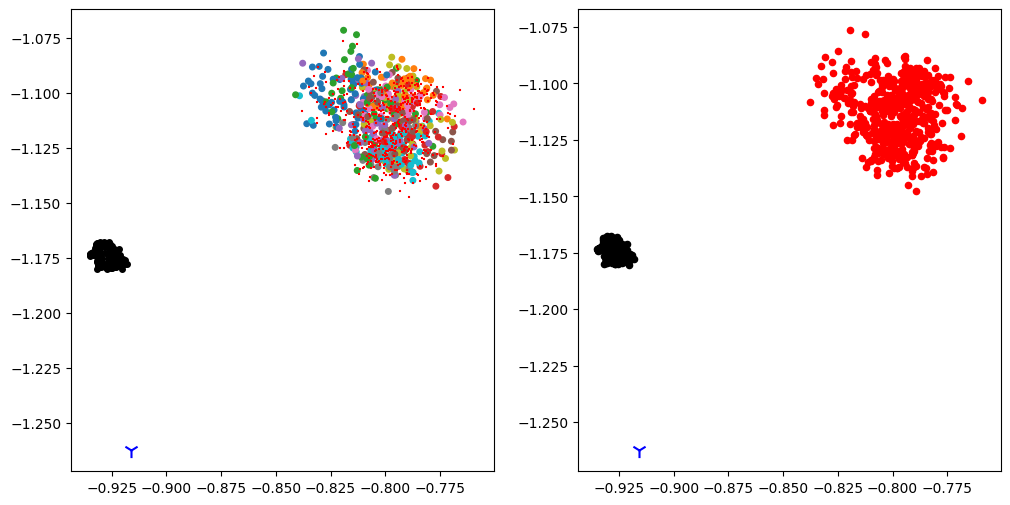

Epoch 62/150
{'G': 0.0025417323235168193, 'POS': 0.9958477751024242, 'NEG': 0.9504984421516532, 'q20': 0.8160862445831298, 'q80': 0.8348503708839417, 'auc': 0.8729026052123551}


Epoch 63/150
{'G': 0.0025240323560407705, 'POS': 0.99602907565611, 'NEG': 0.9505844549583727, 'q20': 0.8219955325126648, 'q80': 0.8406742453575134, 'auc': 0.8555211554054054}


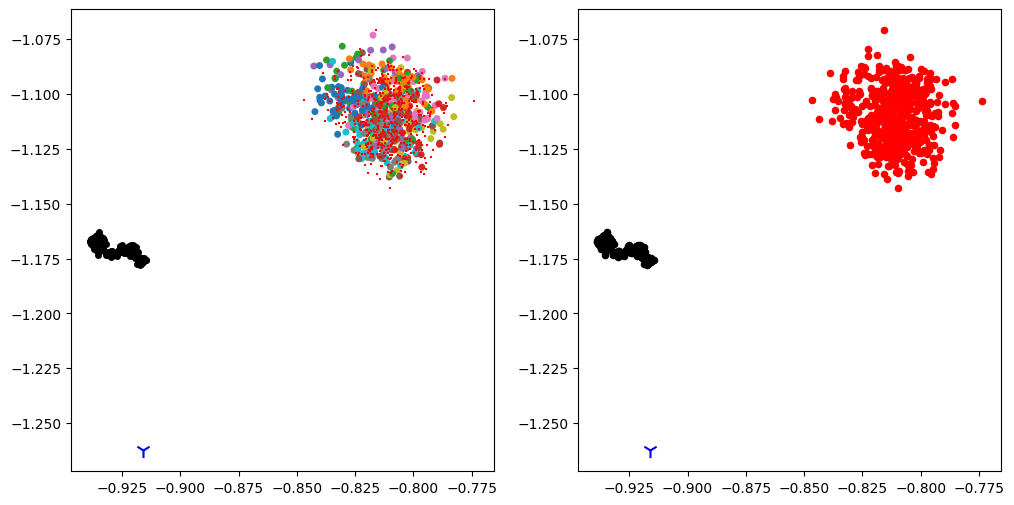

Epoch 64/150
{'G': 0.0025223408803852127, 'POS': 0.9962938696082467, 'NEG': 0.9503640461323867, 'q20': 0.8204576849937439, 'q80': 0.8382350087165833, 'auc': 0.8986936056949807}


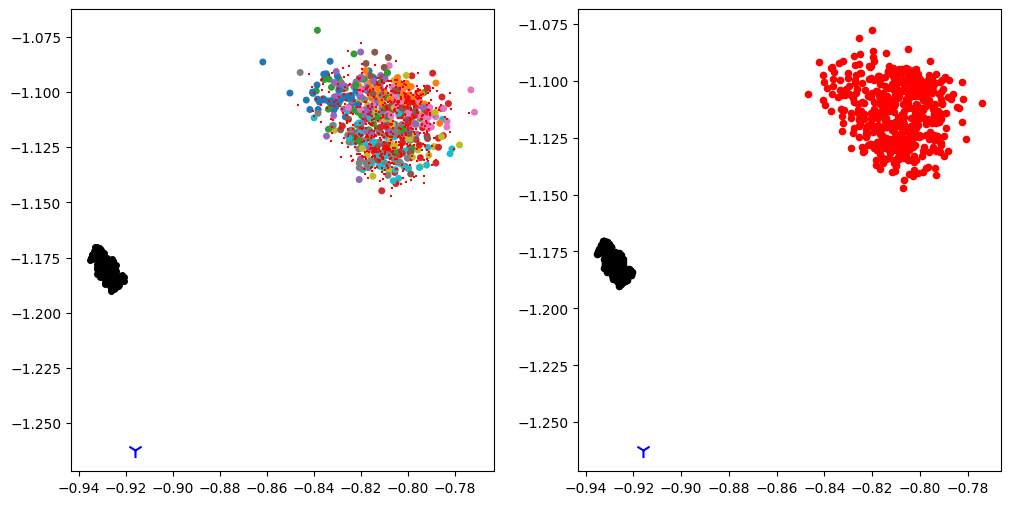

Epoch 65/150
{'G': 0.0025276994433945047, 'POS': 0.9965217910341616, 'NEG': 0.9502390103299481, 'q20': 0.8220610737800598, 'q80': 0.840068256855011, 'auc': 0.8664256467181467}


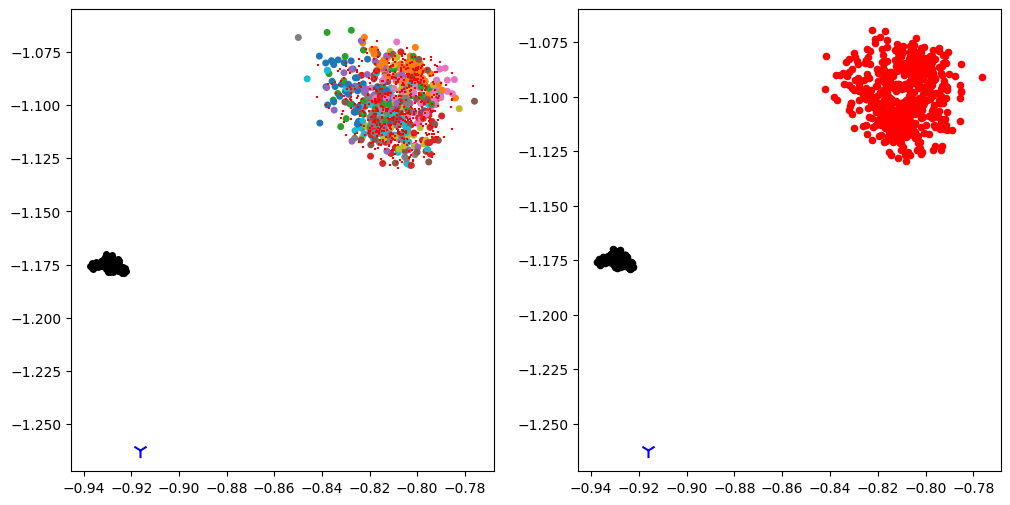

Epoch 66/150
{'G': 0.0025072388076928377, 'POS': 0.9965796728632343, 'NEG': 0.9503001327962001, 'q20': 0.811458158493042, 'q80': 0.8300570011138916, 'auc': 0.8775688431467181}


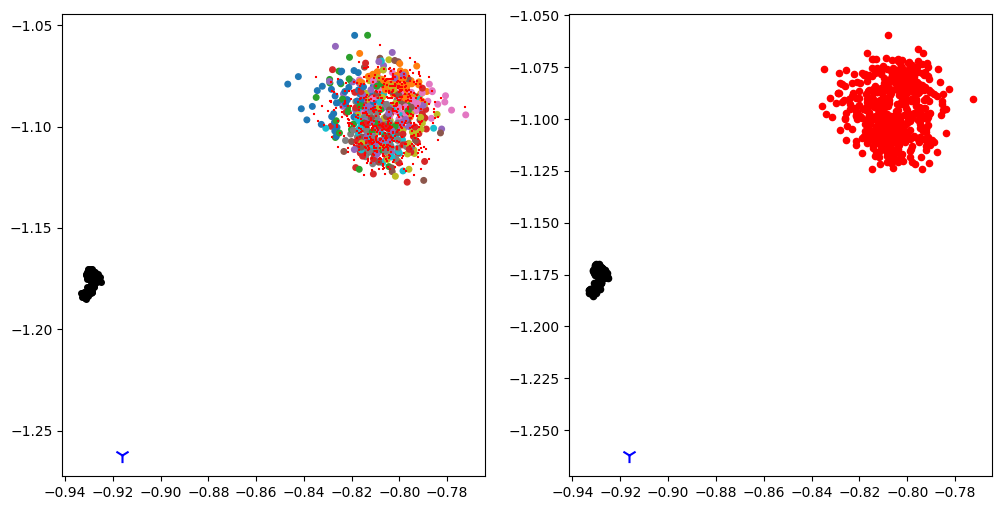

Epoch 67/150
{'G': 0.0025148802433909573, 'POS': 0.9967409879414003, 'NEG': 0.9502713703143317, 'q20': 0.8070950508117676, 'q80': 0.826032280921936, 'auc': 0.8759816520270269}


Epoch 68/150
{'G': 0.0025190461023863573, 'POS': 0.9963578480138962, 'NEG': 0.950385456019119, 'q20': 0.8075154662132263, 'q80': 0.8272224068641663, 'auc': 0.896439263030888}


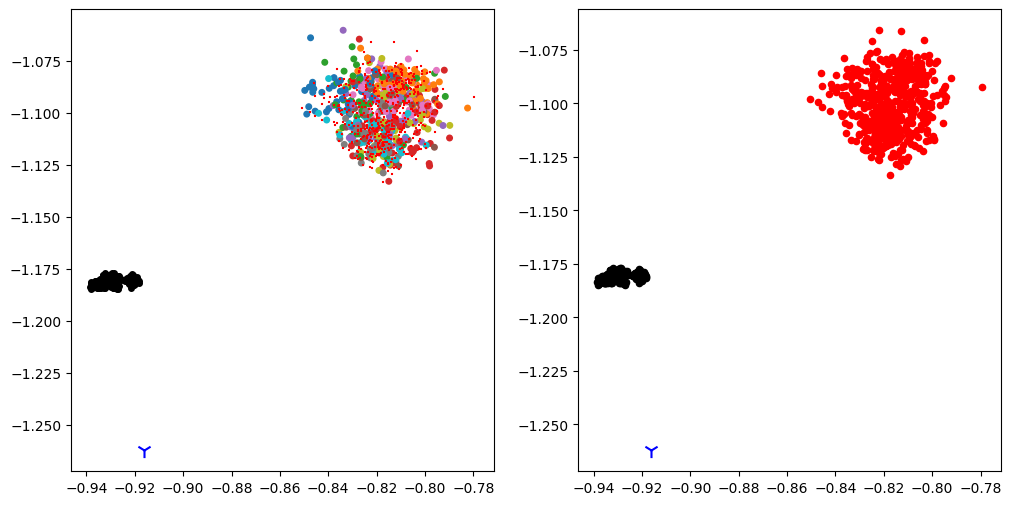

Epoch 69/150
{'G': 0.0025119657130804715, 'POS': 0.9966219897463378, 'NEG': 0.9503499453764226, 'q20': 0.8153478980064393, 'q80': 0.834752893447876, 'auc': 0.8934345043436294}


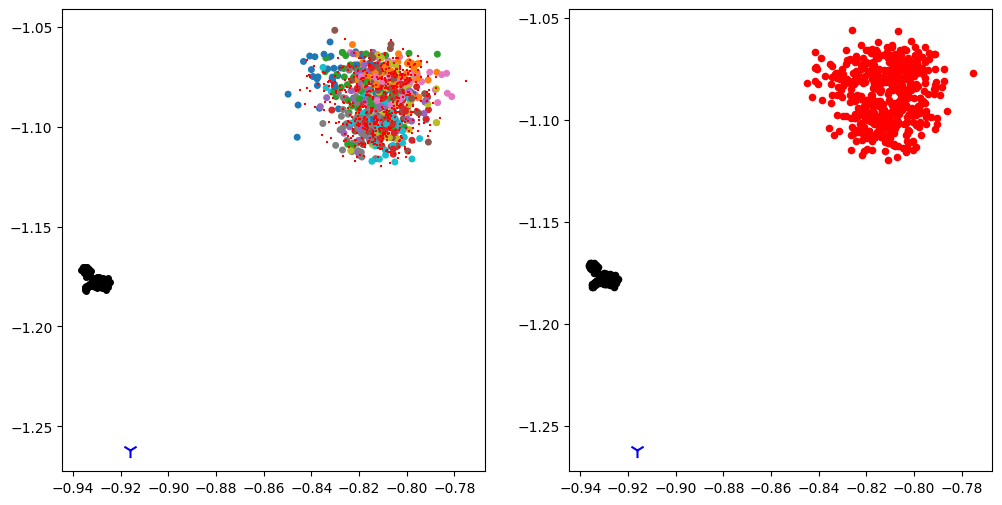

Epoch 70/150
{'G': 0.0025197010433206015, 'POS': 0.9968474987727493, 'NEG': 0.9503176620265822, 'q20': 0.8037952184677124, 'q80': 0.8233967423439026, 'auc': 0.8829746520270272}


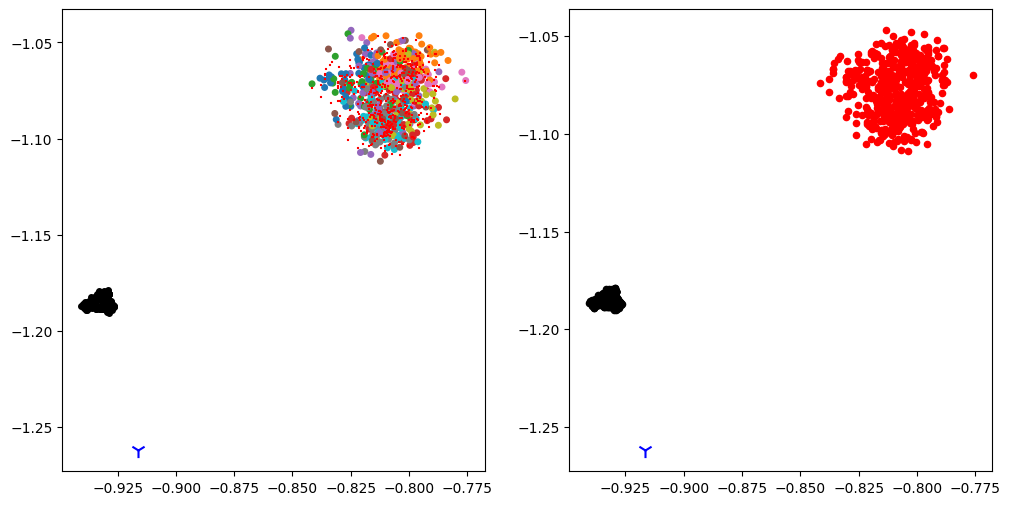

Epoch 71/150
{'G': 0.0025154373351373334, 'POS': 0.9967287564074306, 'NEG': 0.950281634132491, 'q20': 0.7955884218215943, 'q80': 0.8150339126586914, 'auc': 0.868668641891892}


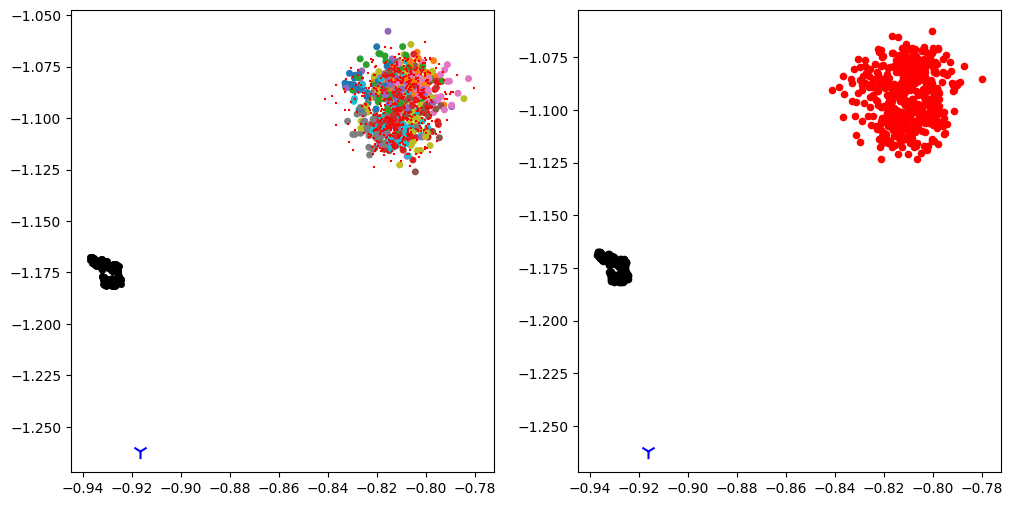

Epoch 72/150
{'G': 0.0025249339197315514, 'POS': 0.9968918636917814, 'NEG': 0.9502763823151334, 'q20': 0.8085196375846863, 'q80': 0.8269360661506653, 'auc': 0.8851128388030887}


Epoch 73/150
{'G': 0.0025134847260145808, 'POS': 0.9971240592409553, 'NEG': 0.9501634698941, 'q20': 0.8103666305541992, 'q80': 0.8280987501144409, 'auc': 0.8994516655405406}


Epoch 74/150
{'G': 0.0025152110341769545, 'POS': 0.9972001728472679, 'NEG': 0.9501385393935734, 'q20': 0.8090426564216614, 'q80': 0.8272474050521851, 'auc': 0.8789045661196911}


Epoch 75/150
{'G': 0.0025139798431087343, 'POS': 0.9969675209222317, 'NEG': 0.9503397869148742, 'q20': 0.8167644381523133, 'q80': 0.8355513572692871, 'auc': 0.8921836225868726}


Epoch 76/150
{'G': 0.0025330798547548144, 'POS': 0.9970359185865438, 'NEG': 0.950248631968427, 'q20': 0.8414239525794983, 'q80': 0.8571264982223511, 'auc': 0.9062073672779922}


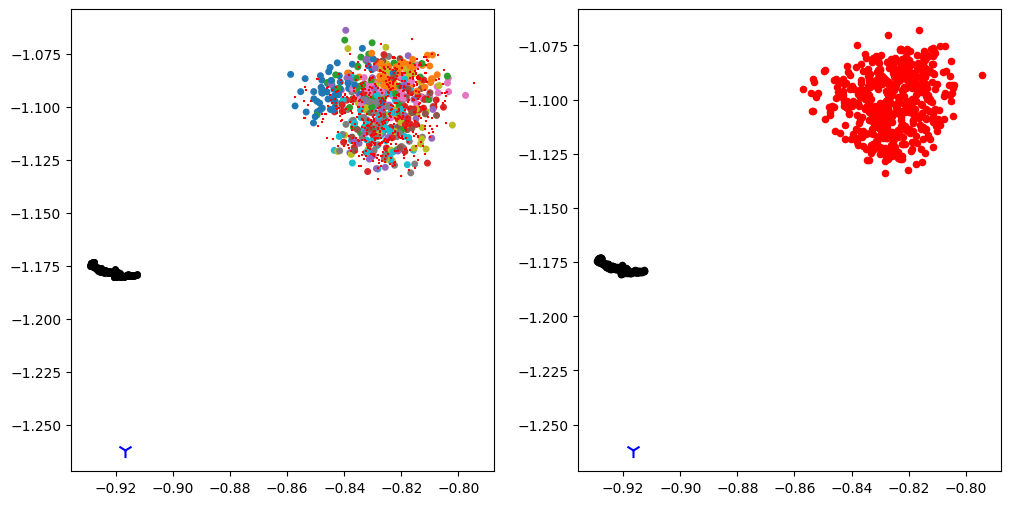

Epoch 77/150
{'G': 0.0025323386858108203, 'POS': 0.9974314780123452, 'NEG': 0.9501600054535531, 'q20': 0.8188274025917053, 'q80': 0.8391195893287658, 'auc': 0.8753104300193051}


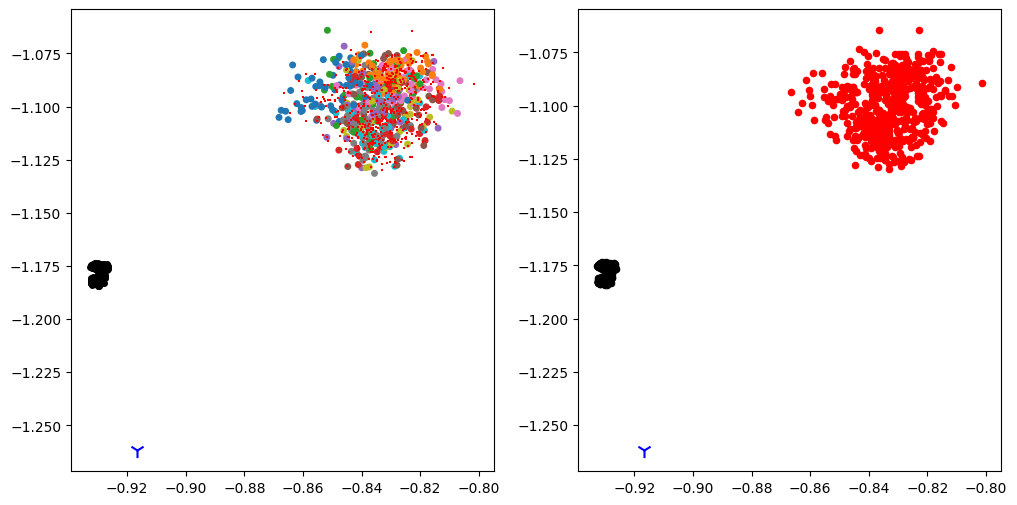

Epoch 78/150
{'G': 0.0025155729716464974, 'POS': 0.9974228247904828, 'NEG': 0.9501587410471333, 'q20': 0.8208255767822266, 'q80': 0.841433298587799, 'auc': 0.8985229000965251}


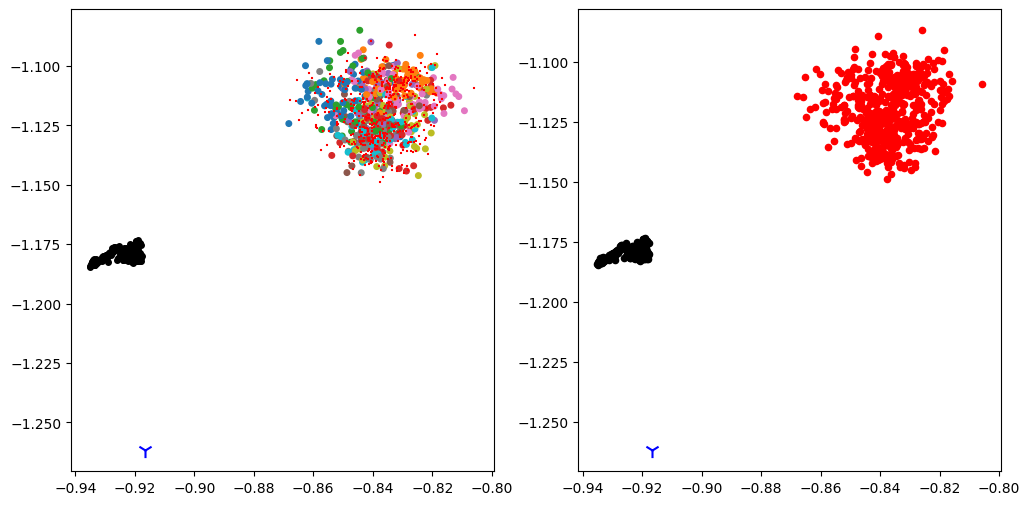

Epoch 79/150
{'G': 0.0025171351237798425, 'POS': 0.9971861404650755, 'NEG': 0.9501785371603488, 'q20': 0.8387329816818238, 'q80': 0.8573777437210083, 'auc': 0.9114641833976834}


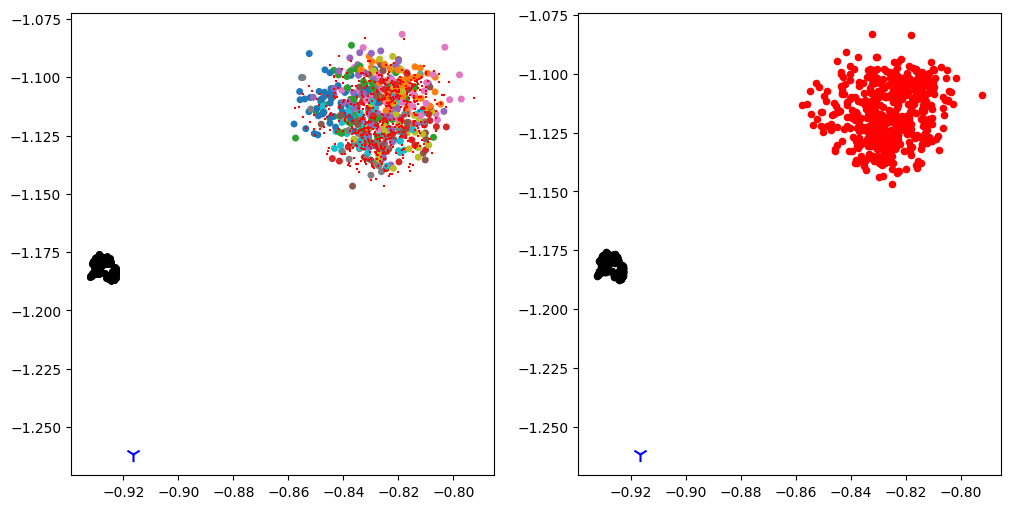

Epoch 80/150
{'G': 0.002511536356991034, 'POS': 0.9976032178030848, 'NEG': 0.9500957550778826, 'q20': 0.8317547917366028, 'q80': 0.8504500031471253, 'auc': 0.8979503243243244}


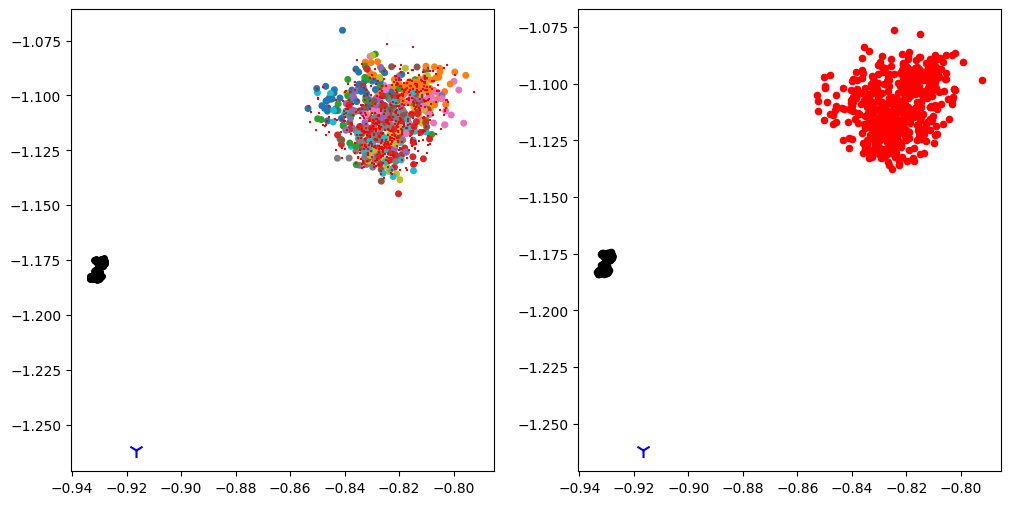

Epoch 81/150
{'G': 0.0025113186873952304, 'POS': 0.9974772184134038, 'NEG': 0.9501684883764303, 'q20': 0.8256528854370118, 'q80': 0.8450653553009033, 'auc': 0.8913761008687259}


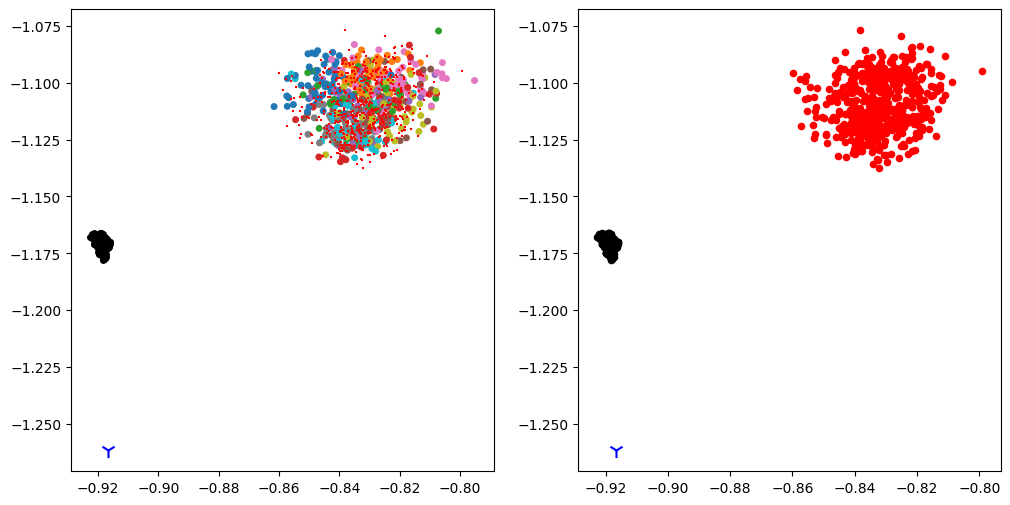

Epoch 82/150
{'G': 0.0025152576355529682, 'POS': 0.9974640731109994, 'NEG': 0.9502417978955738, 'q20': 0.8286718010902405, 'q80': 0.8473652958869934, 'auc': 0.8924023334942085}


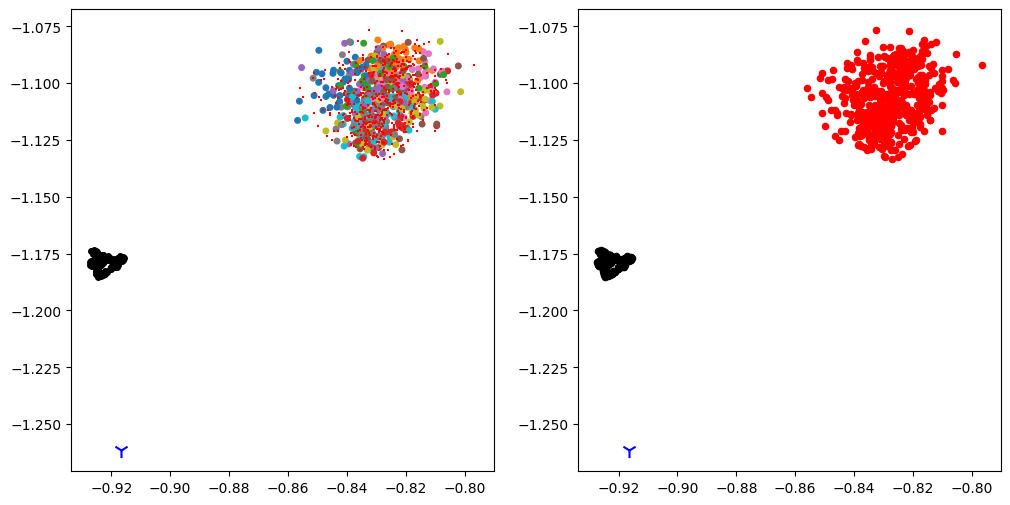

Epoch 83/150
{'G': 0.0025059982368758303, 'POS': 0.9975579655500871, 'NEG': 0.9501518491488784, 'q20': 0.8251254916191101, 'q80': 0.8439383625984191, 'auc': 0.8775322717181467}


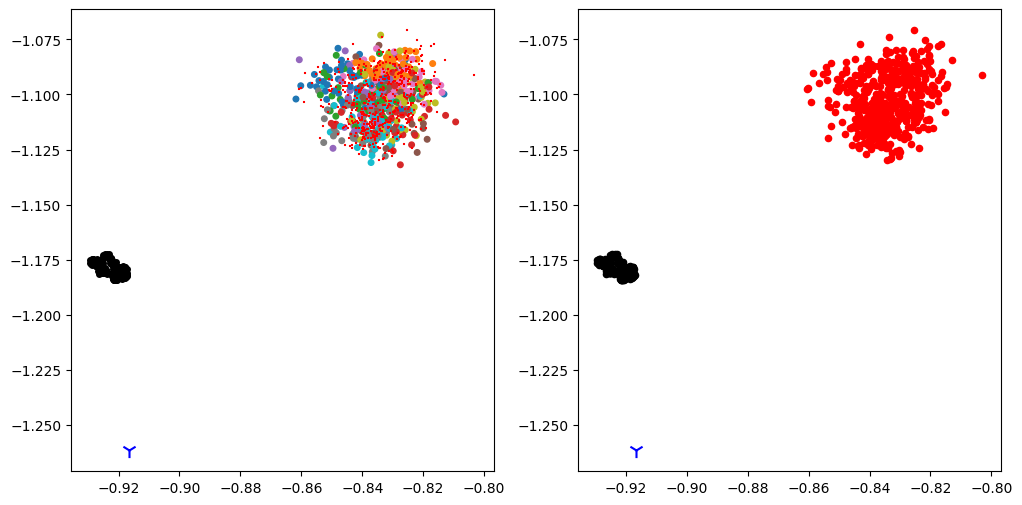

Epoch 84/150
{'G': 0.0025061666156286433, 'POS': 0.9974988482908399, 'NEG': 0.9502048098456377, 'q20': 0.8248688340187073, 'q80': 0.843276035785675, 'auc': 0.8995385868725868}


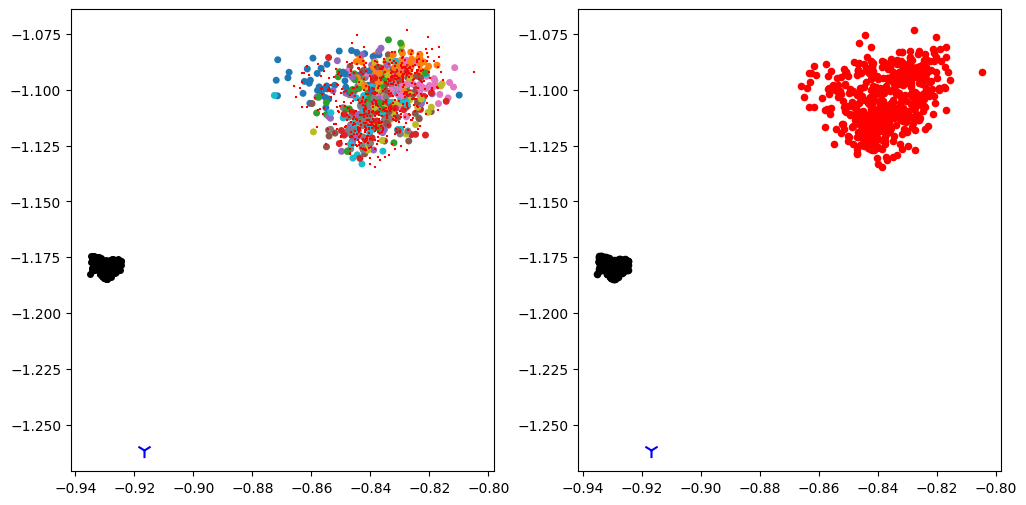

Epoch 85/150
{'G': 0.0025108859592329847, 'POS': 0.997531092243154, 'NEG': 0.950184235821909, 'q20': 0.8267756819725036, 'q80': 0.846621322631836, 'auc': 0.9037001496138997}


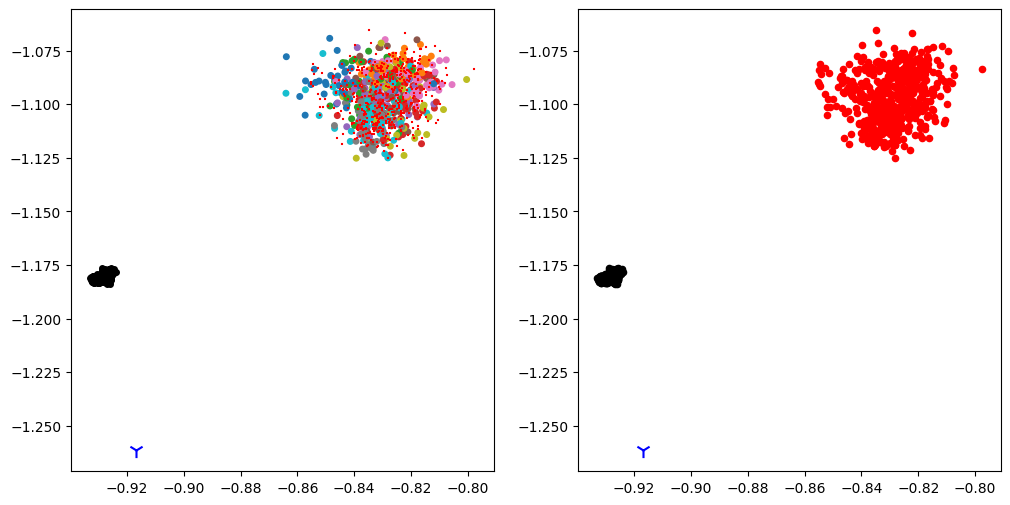

Epoch 86/150
{'G': 0.0025076679716597616, 'POS': 0.997462226129544, 'NEG': 0.9502154194724077, 'q20': 0.8181271314620971, 'q80': 0.8367296576499939, 'auc': 0.8966700111003861}


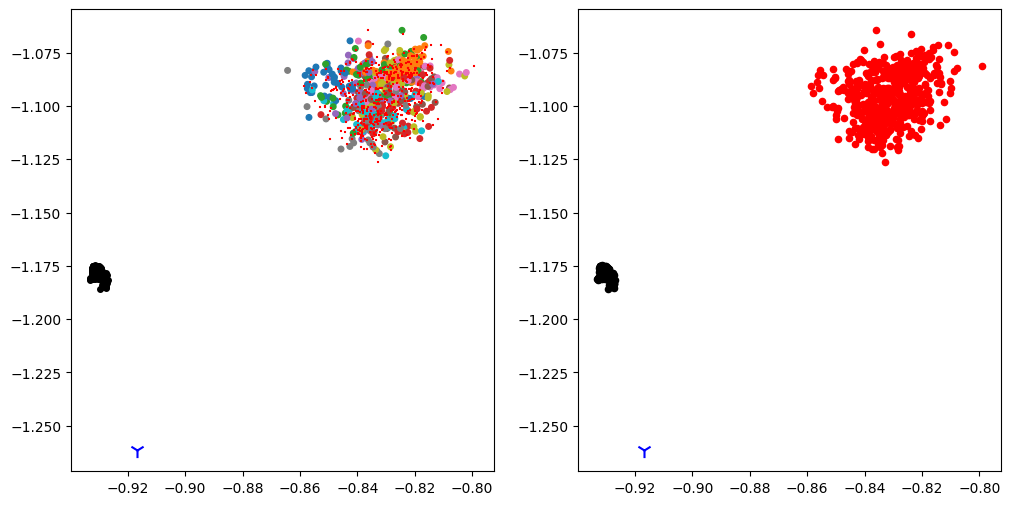

Epoch 87/150
{'G': 0.002503794976381033, 'POS': 0.9977015584770804, 'NEG': 0.9501529372831398, 'q20': 0.8185311555862427, 'q80': 0.8369373440742492, 'auc': 0.9024633653474903}


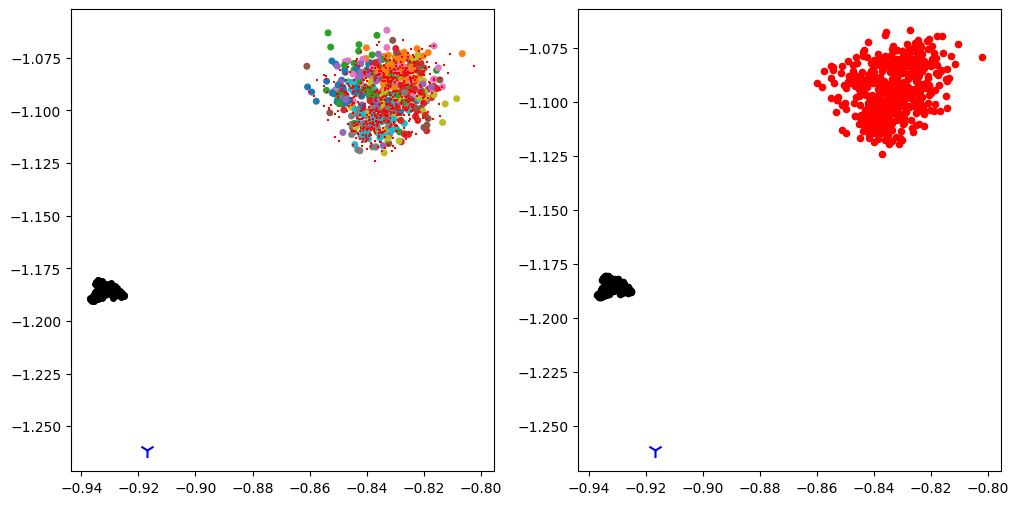

Epoch 88/150
{'G': 0.0025025876521913293, 'POS': 0.9978337477265137, 'NEG': 0.950107103471817, 'q20': 0.8179263234138489, 'q80': 0.836573600769043, 'auc': 0.895471498069498}


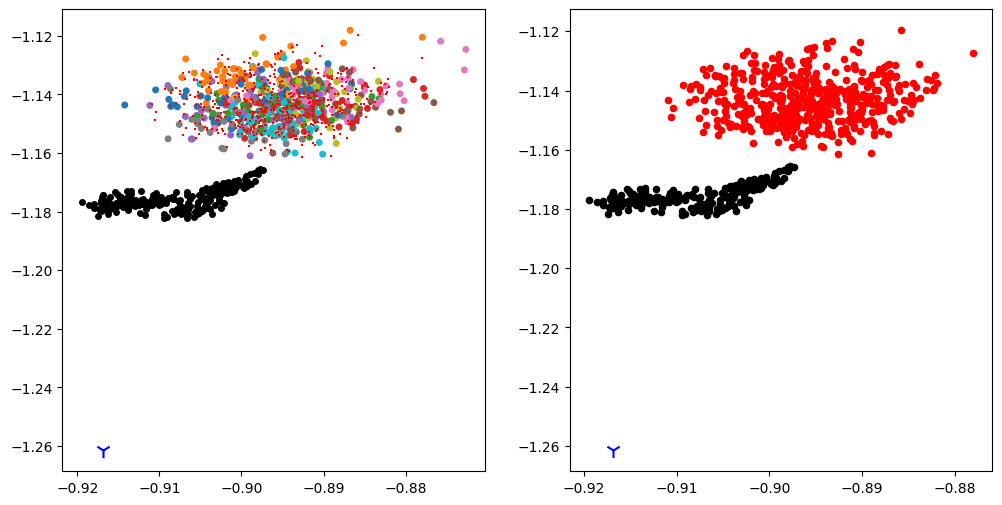

Epoch 89/150
{'G': 0.0025505267333354492, 'POS': 0.9977811103436485, 'NEG': 0.950146352558502, 'q20': 0.8795025467872619, 'q80': 0.8913669943809509, 'auc': 0.9088322784749034}


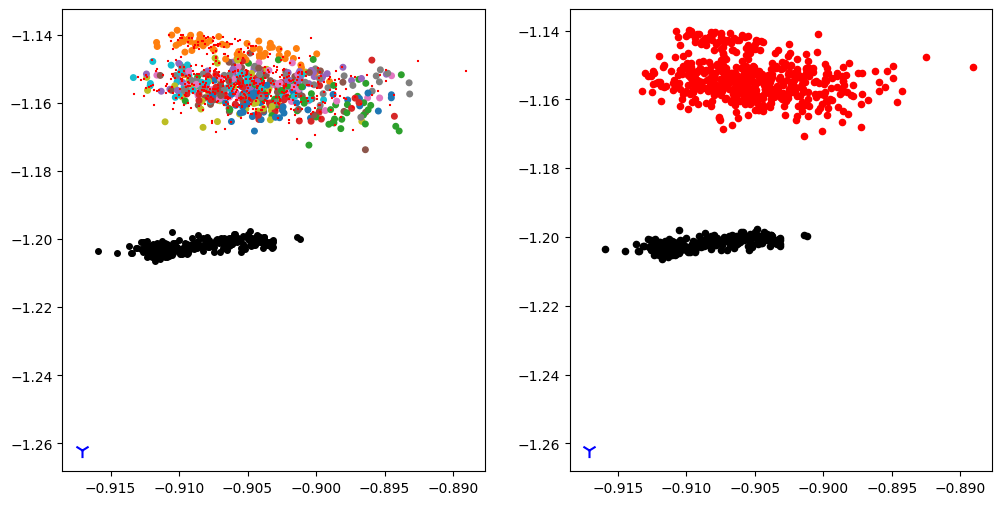

Epoch 90/150
{'G': 0.0026352755320288223, 'POS': 0.9975648896018071, 'NEG': 0.950082720723996, 'q20': 0.8934072613716125, 'q80': 0.9013123869895935, 'auc': 0.7055032528957529}


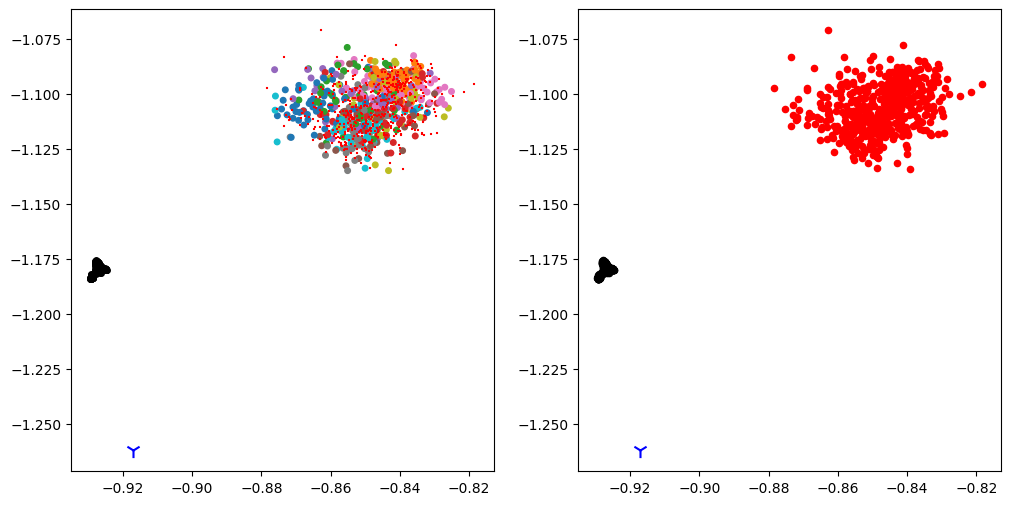

Epoch 91/150
{'G': 0.002544896458702555, 'POS': 0.9978113483264248, 'NEG': 0.9501288674279317, 'q20': 0.8312487363815307, 'q80': 0.8500378370285034, 'auc': 0.912411125965251}


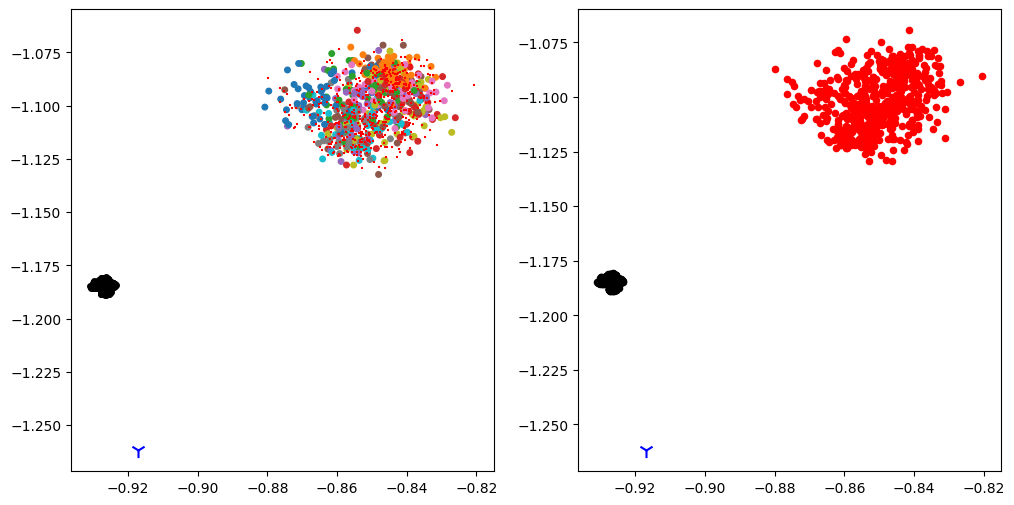

Epoch 92/150
{'G': 0.00251015870303694, 'POS': 0.9977275666905873, 'NEG': 0.9501628705433437, 'q20': 0.8271858930587769, 'q80': 0.8476898550987244, 'auc': 0.8873303643822394}


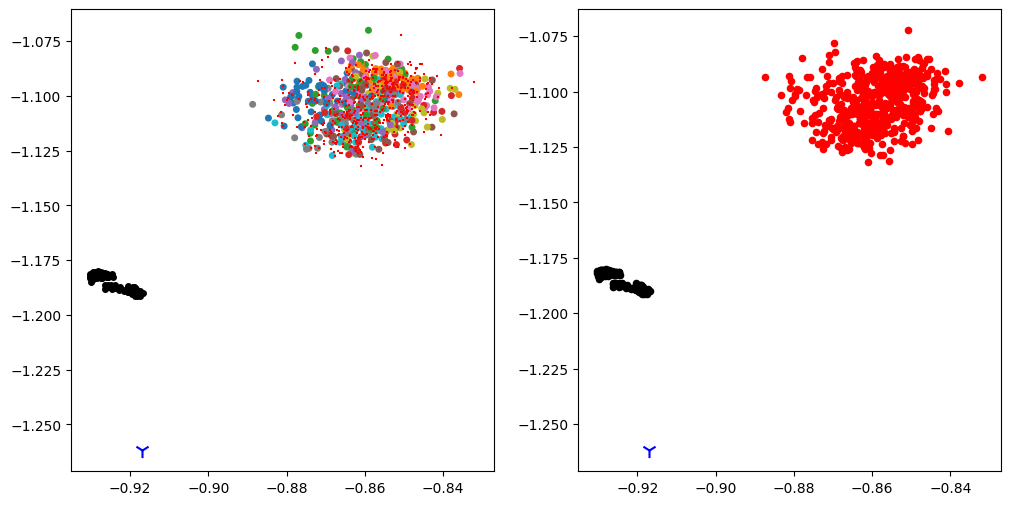

Epoch 93/150
{'G': 0.002505423710631854, 'POS': 0.997841316372601, 'NEG': 0.9501339606384733, 'q20': 0.8342777848243713, 'q80': 0.8521811485290527, 'auc': 0.9190747466216216}


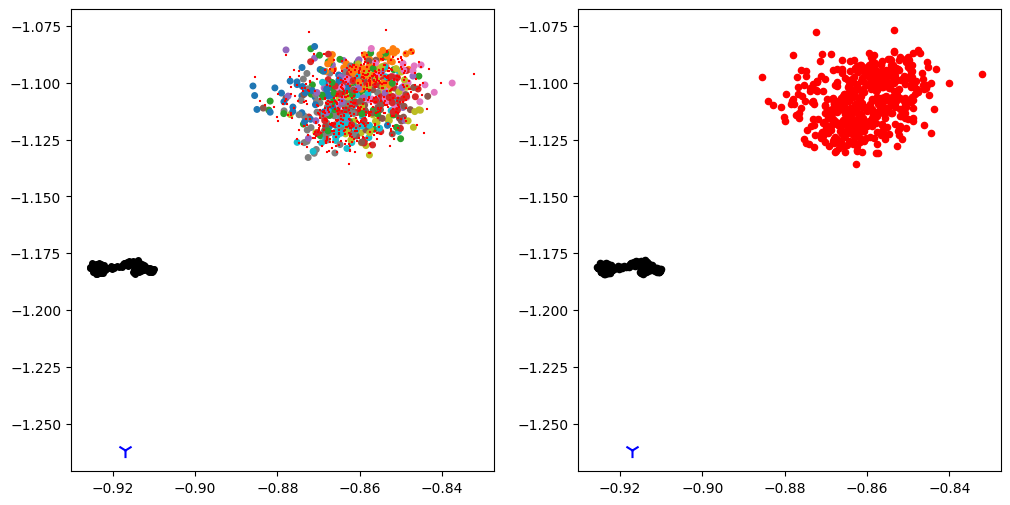

Epoch 94/150
{'G': 0.0025060901498751664, 'POS': 0.9979094765079555, 'NEG': 0.9500970083004885, 'q20': 0.8379387736320496, 'q80': 0.8556549668312072, 'auc': 0.9153127741312741}


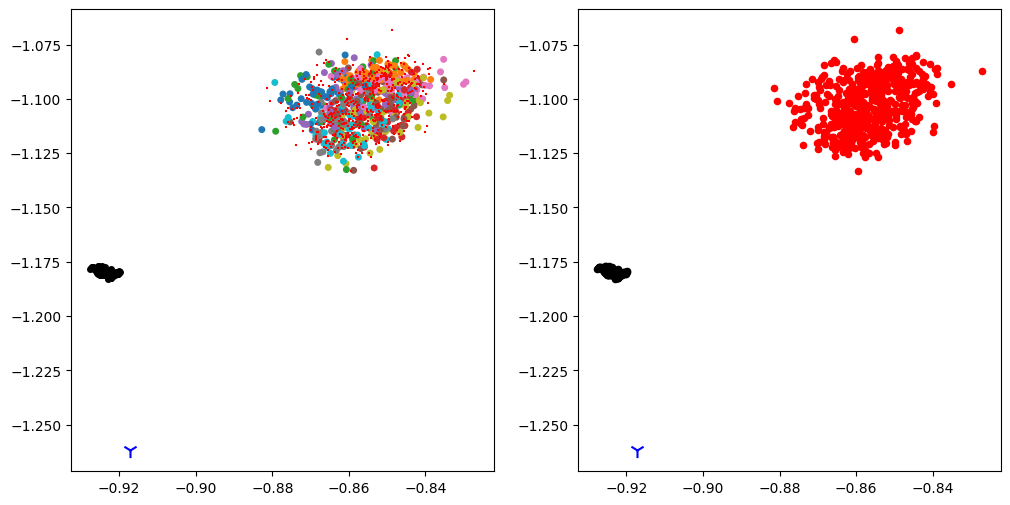

Epoch 95/150
{'G': 0.002507387941925606, 'POS': 0.9978413105265164, 'NEG': 0.9501159821492015, 'q20': 0.832178795337677, 'q80': 0.8506086707115174, 'auc': 0.8981623122586873}


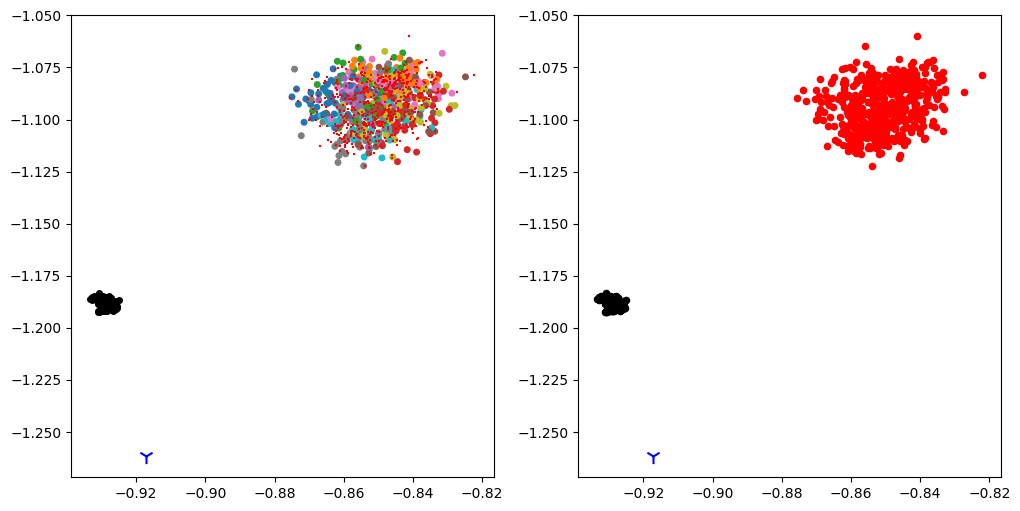

Epoch 96/150
{'G': 0.0025054421821938777, 'POS': 0.9978350079390031, 'NEG': 0.9501276969401313, 'q20': 0.8232843279838562, 'q80': 0.8408883452415467, 'auc': 0.9022942253861004}


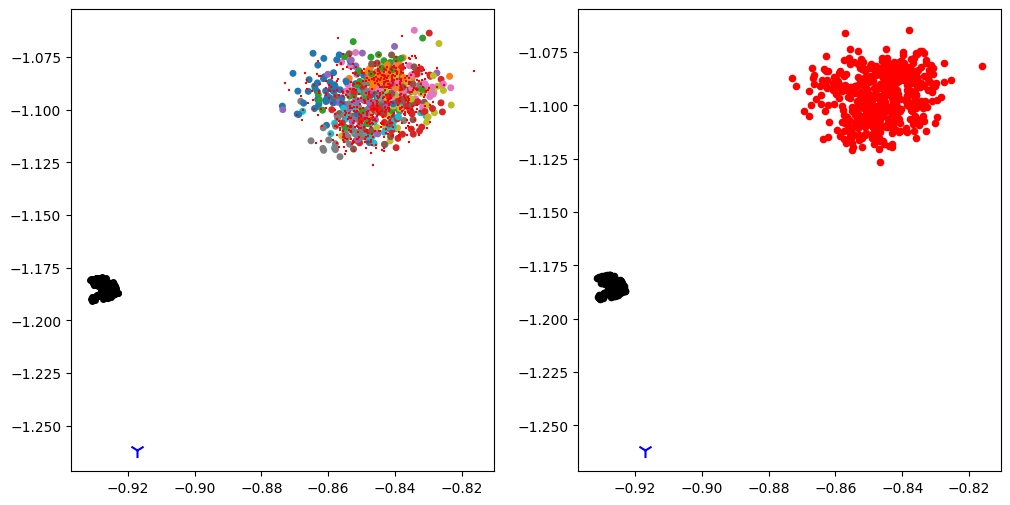

Epoch 97/150
{'G': 0.002502166248087499, 'POS': 0.9981031473765749, 'NEG': 0.9501088172642153, 'q20': 0.8240320563316346, 'q80': 0.841540801525116, 'auc': 0.9083894290540541}


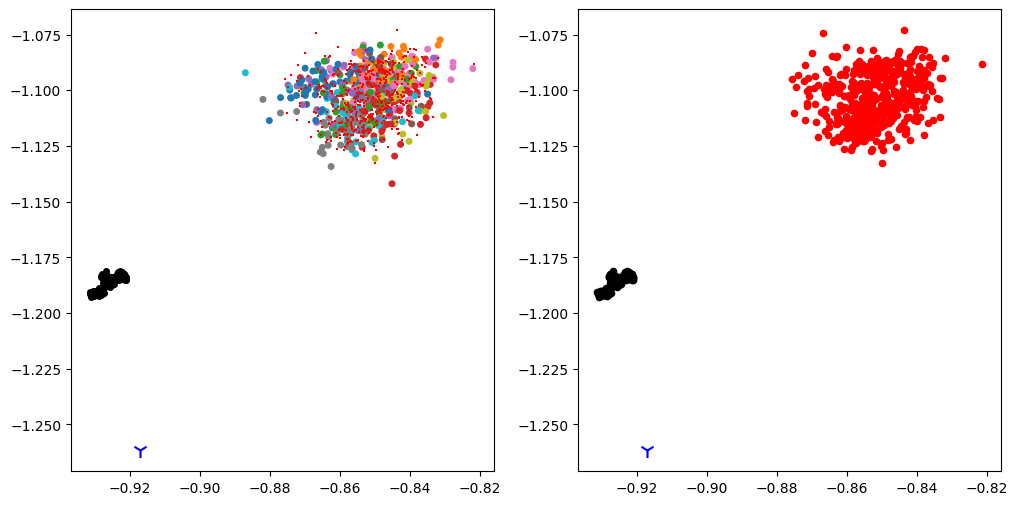

Epoch 98/150
{'G': 0.0025049685316879166, 'POS': 0.9980719437731355, 'NEG': 0.9501201779857628, 'q20': 0.8312886238098145, 'q80': 0.8489163041114807, 'auc': 0.9186422799227799}


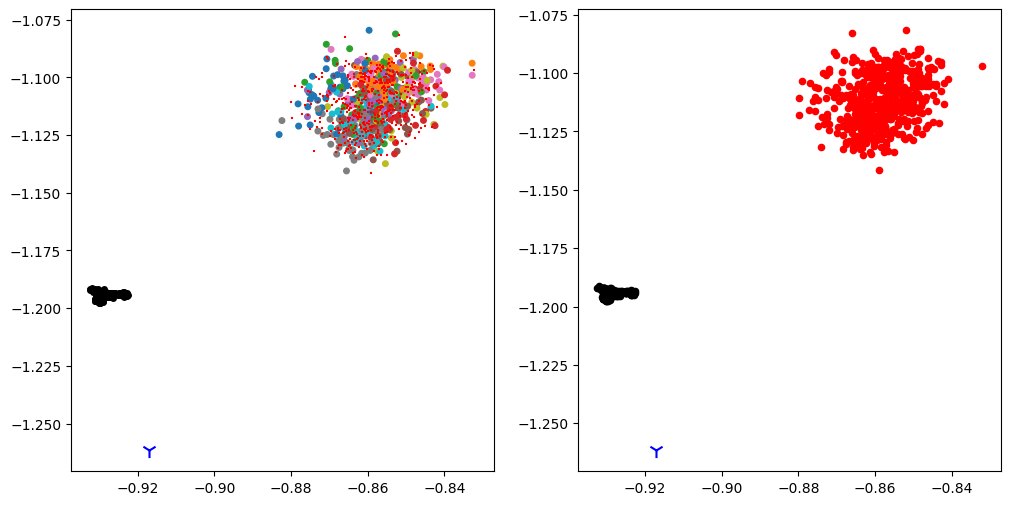

Epoch 99/150
{'G': 0.0025041725929341972, 'POS': 0.9980097250389391, 'NEG': 0.9501191451351272, 'q20': 0.8401799321174621, 'q80': 0.8575742959976197, 'auc': 0.9054874406370657}


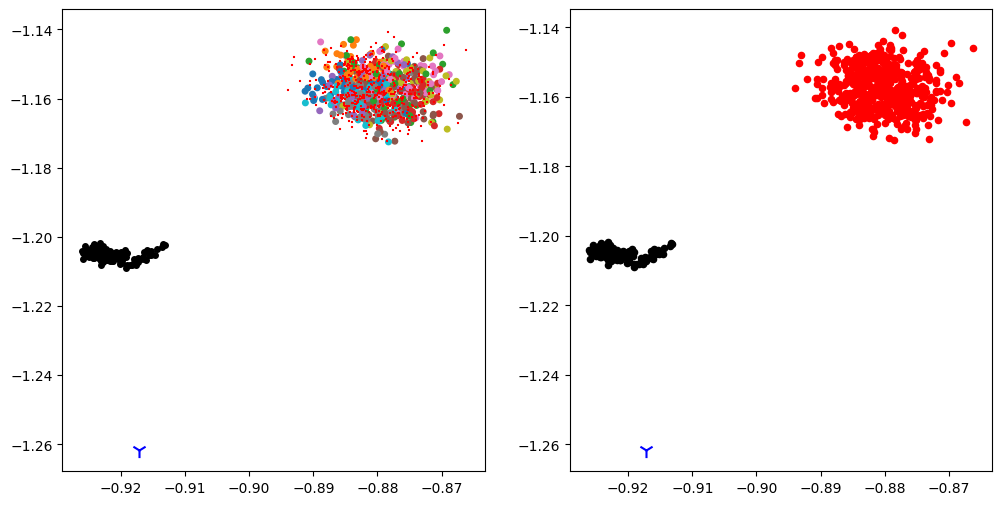

Epoch 100/150
{'G': 0.0025432289981130343, 'POS': 0.997900221266472, 'NEG': 0.9501639319889581, 'q20': 0.8892688632011414, 'q80': 0.8982663154602051, 'auc': 0.953724584942085}


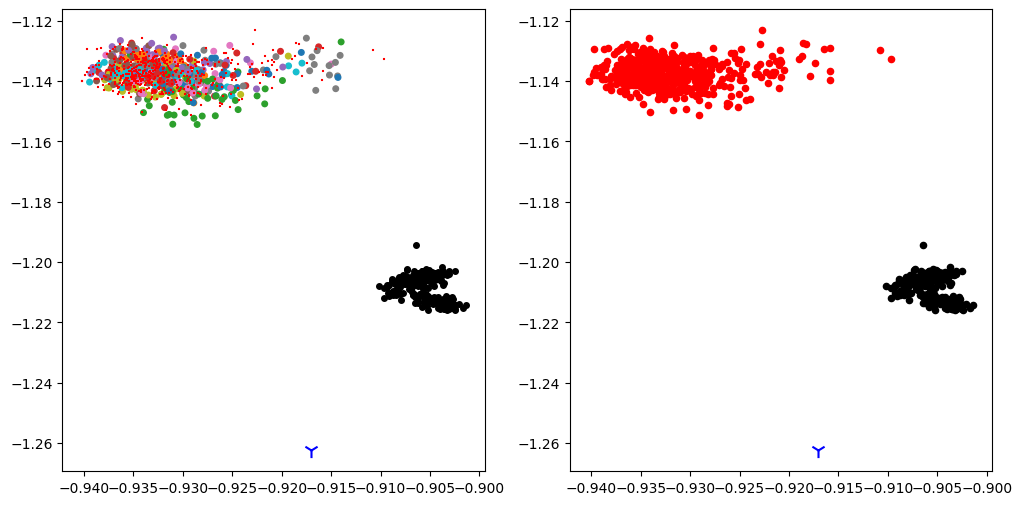

Epoch 101/150
{'G': 0.0026871325350853043, 'POS': 0.9976282072728122, 'NEG': 0.9501031934579552, 'q20': 0.8784724116325379, 'q80': 0.8853264689445496, 'auc': 0.666568902027027}


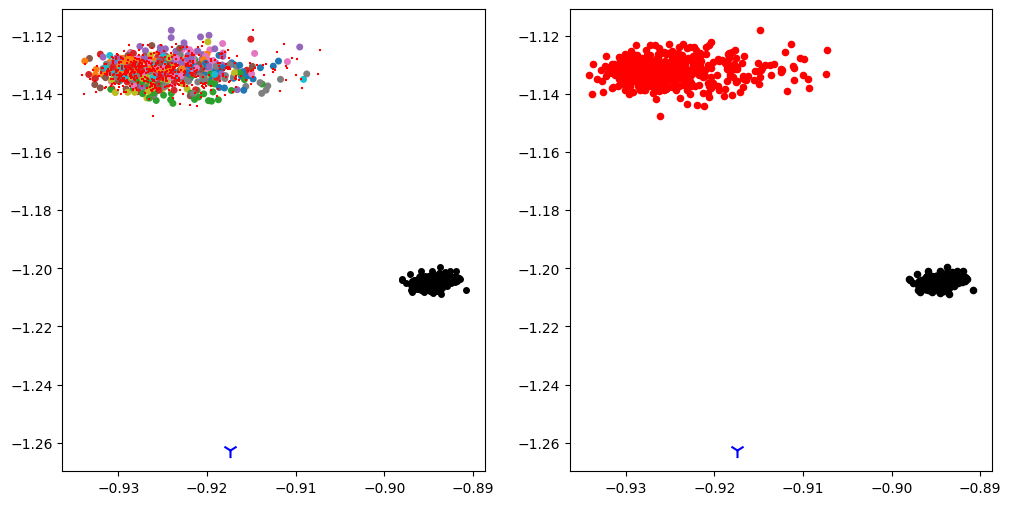

Epoch 102/150
{'G': 0.0025551543990050807, 'POS': 0.9979619546485609, 'NEG': 0.9500230834174004, 'q20': 0.8740718722343445, 'q80': 0.8798550248146058, 'auc': 0.6357145863899614}


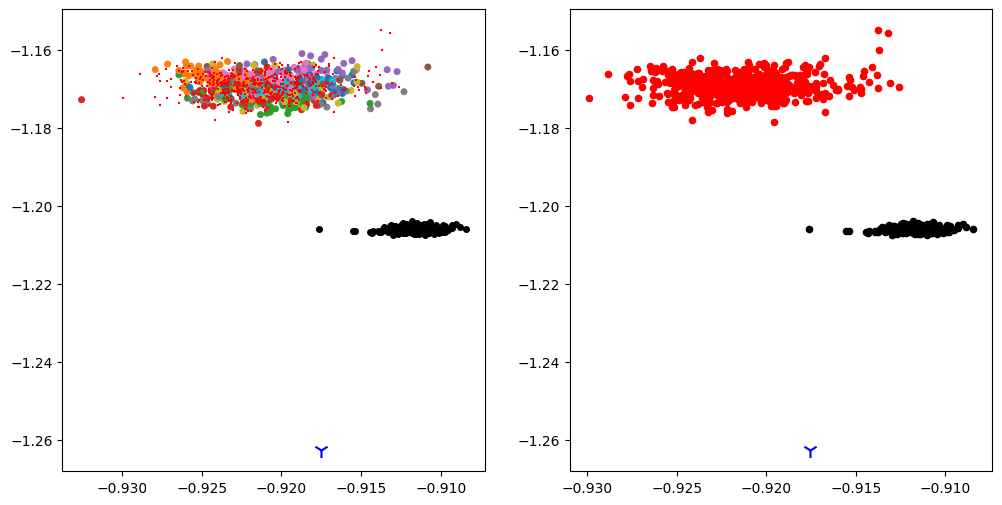

Epoch 103/150
{'G': 0.0025283013741527476, 'POS': 0.9982136692573775, 'NEG': 0.95001722131965, 'q20': 0.907932984828949, 'q80': 0.912627351284027, 'auc': 0.905140192084942}


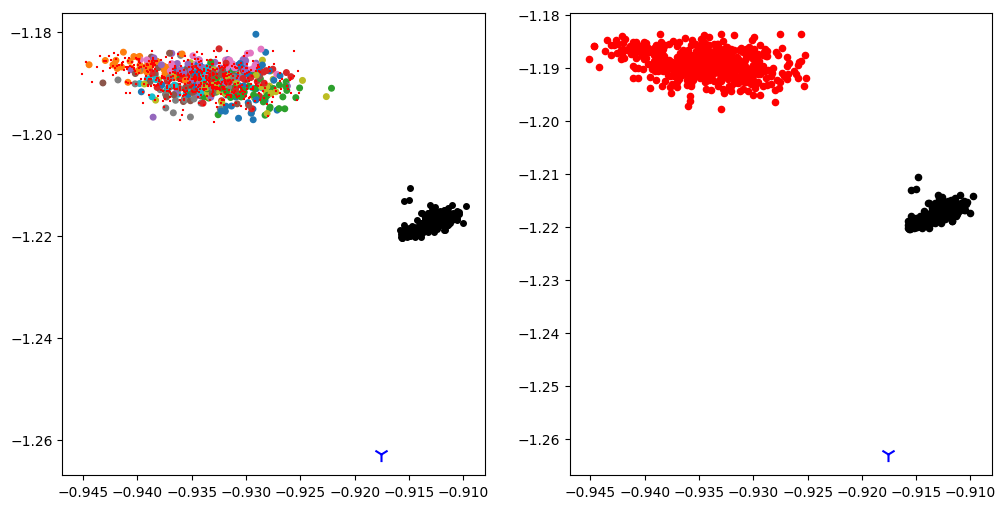

Epoch 104/150
{'G': 0.002530524058879089, 'POS': 0.9982877247877466, 'NEG': 0.9500285909374131, 'q20': 0.9252676129341125, 'q80': 0.9298330187797547, 'auc': 0.681361709942085}


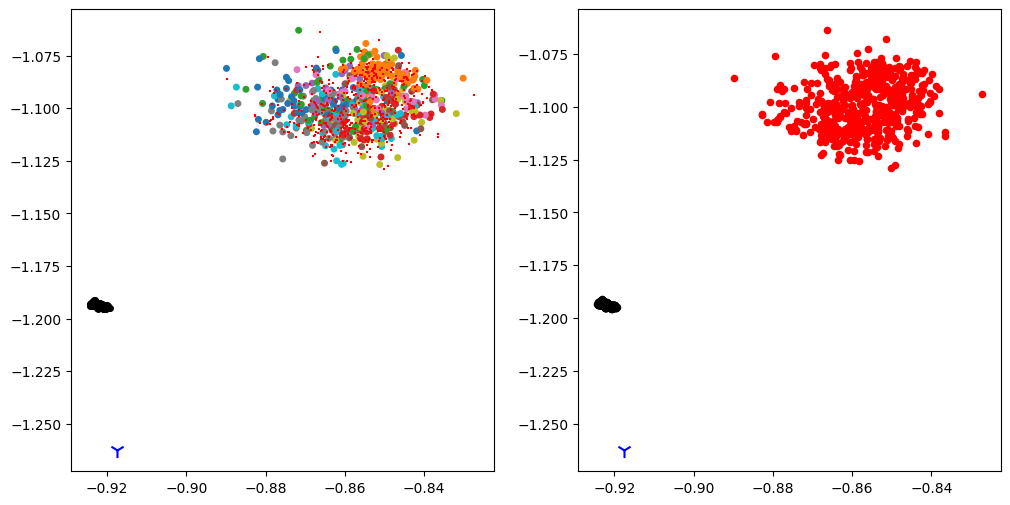

Epoch 105/150
{'G': 0.0025401142624907817, 'POS': 0.9977339920458763, 'NEG': 0.9502397417259623, 'q20': 0.8279291868209839, 'q80': 0.8471571683883667, 'auc': 0.8987495304054055}


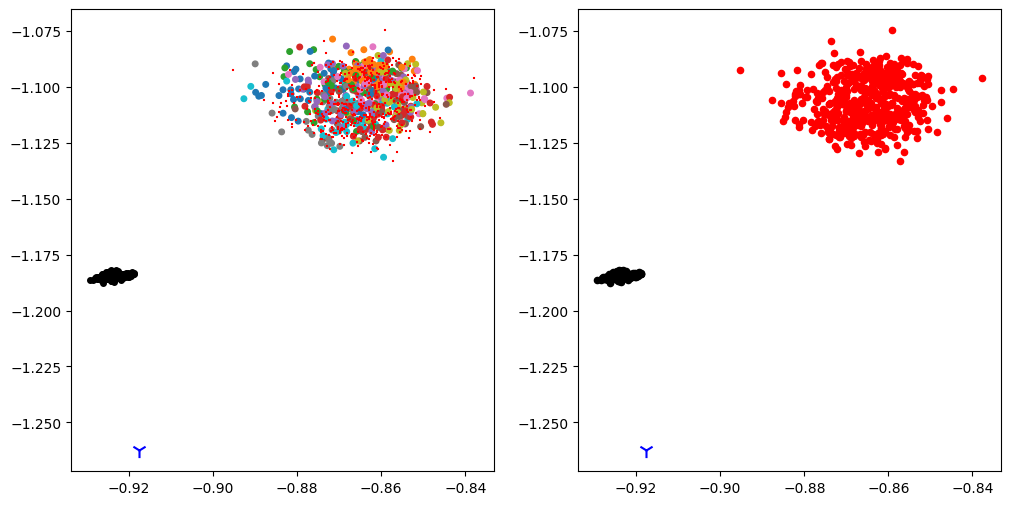

Epoch 106/150
{'G': 0.0025150036483482796, 'POS': 0.9975759814034647, 'NEG': 0.9501730630646891, 'q20': 0.8374005317687988, 'q80': 0.8536623477935791, 'auc': 0.933750415057915}


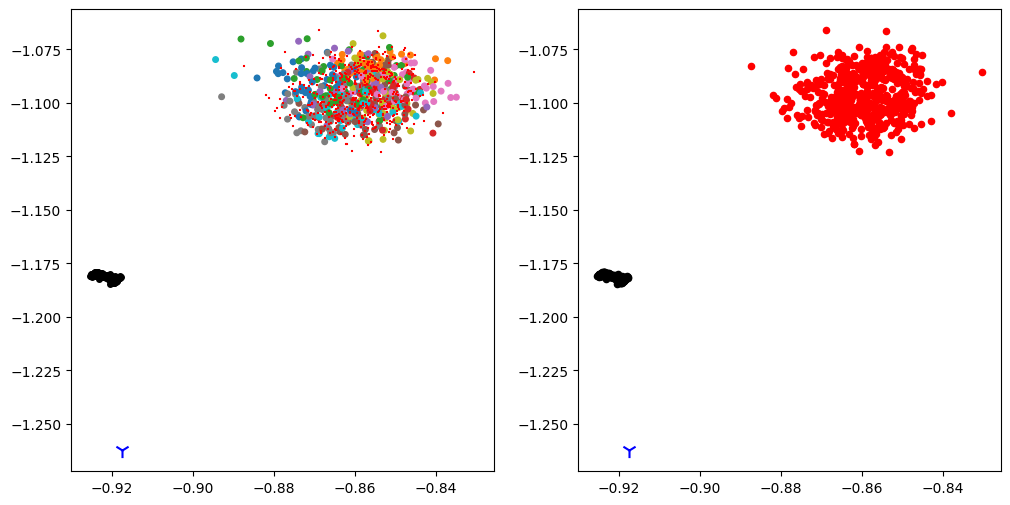

Epoch 107/150
{'G': 0.002507479263167741, 'POS': 0.9979916125980776, 'NEG': 0.9500975842669066, 'q20': 0.8275310277938843, 'q80': 0.8442693948745728, 'auc': 0.9295041023166024}


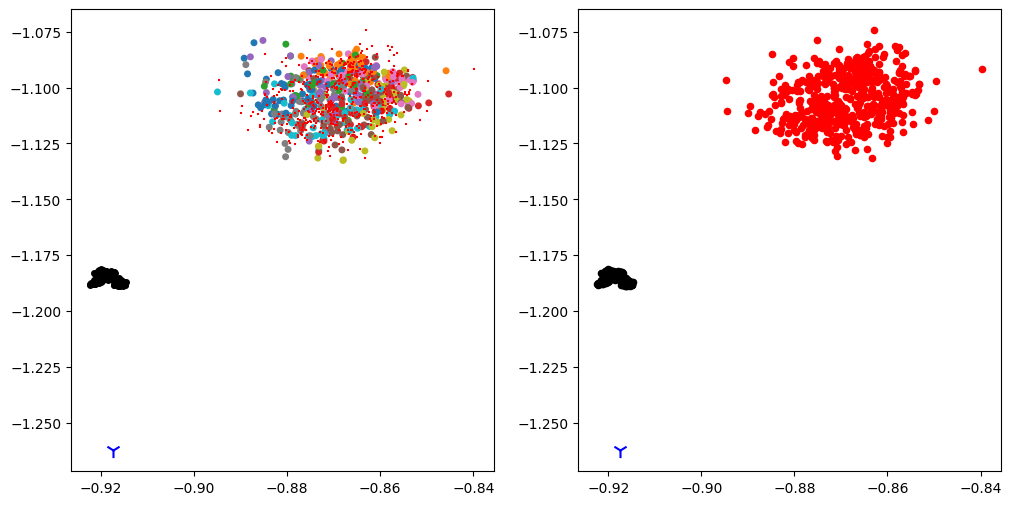

Epoch 108/150
{'G': 0.00250457717266593, 'POS': 0.9981875087914944, 'NEG': 0.9500678561643751, 'q20': 0.8371984720230102, 'q80': 0.8543637037277222, 'auc': 0.9253512881274131}


In [15]:
for epoch in range(niter):

    netG.train()
    netD.train()
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        netD.zero_grad()
        
        firing_c = netD(real_cpu)
        #firing_c = torch.clamp(firing_c,0, 8)
        errD_real = torch.square(firing_c - 1.0).mean()
        errD_real.backward()
        
        neg_firing_c = netD(fake.detach())
        errD_fake = torch.square(neg_firing_c-0.95).mean()
        errD_fake.backward()
        
        optimizerD.step()
        
        netD.zero_grad()
        netG.zero_grad()
        gcore = netD(fake)
        errG = torch.square(gcore - 1.0).mean() 
        errG.backward()
        optimizerG.step()
        
        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing_c.mean().item()
        report_aver_neg += neg_firing_c.mean().item()
        
    netG.eval()
    netD.eval()

    losses = {}
    
    losses['G'] = report_loss_G / local_count
    losses['POS'] = report_aver_pos / local_count
    losses['NEG'] = report_aver_neg / local_count
    
    writer.add_scalars('Loss', losses, epoch)
    fake = netG(fixed_noise)
    writer.add_images('Generated images', fake.detach(), epoch)
    draw_embeddings(epoch)    
    
    mnist_distr, auc = get_test_arate_distr(netD)
    mnist_distr_q = {}
    mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
    mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
    writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
    writer.add_scalar("AUC", auc, epoch)
    mnist_distr_q["auc"] = auc
    
    print(f"Epoch {epoch}/{niter}")
    print(losses | mnist_distr_q)
#draw_embeddings(epoch)
#num_gpu = 1 if torch.cuda.is_available() else 0

In [ ]:
netD.core[0](torch.tensor([[-6.0, -5.0]]).to(device))

In [ ]:
netD.core[0].get_centroids()

In [ ]:
netD.core[0].get_transformation_matrix()

## Валидация

In [ ]:
D = netD
G = netG
D.eval()
G.eval()

with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [ ]:
def get_arate(inp):
    #output = D.main(inp)
    #c = D.core(output)
    return D.arate(inp)#c.sum(-1)
    
get_arate(inp.to(device))

In [21]:
centroids_r = D.core[0].get_centroids().detach().cpu().numpy()
#centroids_f = D.fake[0].centroids.squeeze(-1).cpu().detach().numpy()
#centroids_r

In [22]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

In [ ]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 6))

R, C = 1, 1
cnt = 1
for i in range(1):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 100)
    #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 20)
    #plt.xlim(-0.5, 0.5)
    #plt.ylim(-0.5, 0.5)
#plt.colorbar()
plt.show()



In [ ]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(12, 6))

R, C = 1, 2

plt.subplot(R, C, 1)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='green', s= 20)
plt.subplot(R, C, 2)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 200)

plt.show()

In [ ]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [ ]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

In [ ]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)